# YouTube, the news the politics. Can we see the divide?

In [1]:
import pandas as pd
import numpy as np

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.colors as mcolors
from colour import Color
sns.set_style('white')
%matplotlib inline

# Stats
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# NLP
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.phrases import Phrases
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from wordcloud import WordCloud, ImageColorGenerator
import pyLDAvis.gensim_models

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

# Other
import random
import googleapiclient.discovery
from itertools import combinations
import json
import gzip
import csv
import urllib.request

## Required files
To run this notebook the following files are required:

```
.
├── data
│   ├── df_channels_en.tsv.gz
│   ├── df_people_channel.tsv.gz
│   ├── df_news_youtube.csv
│   ├── df_news_matched.csv
│   ├── df_timeseries_en.tsv.gz
│   ├── publications.json
│   ├── trump_approval_polllist.csv
│   ├── youtube_comments.tsv.gz (77 GB)
│   ├── yt_metadata_en.jsonl.gz (13 GB)
└── initial_analysis.ipynb
```

`trump_approval_pollist.csv` retrieved from FiveThirtyEight (https://projects.fivethirtyeight.com/trump-approval-ratings/)

`publications.json` retrieved from AllSides (https://www.allsides.com/media-bias/ratings)

In [2]:
BIAS_COLORS = {
  "Left": "#1404bd",
  "Center": "#808080",
  "Right": "#de0100",
}

## 1 Data preparation

### 1.1 Read in Dataset
Read in Additional Dataset: AllSides News Outlets Media Bias Ranking

In [3]:
# The media bias rating dataset from Allsides (https://www.allsides.com/media-bias/ratings)
# It rates major and smaller news outlets with their political leaning
with open("data/publications.json") as f:
  raw = json.load(f)

data = [pub["publication"] for pub in raw["allsides_media_bias_ratings"]]
df_publications = pd.DataFrame.from_records(data)
df_news = df_publications[df_publications.source_type == "News Media"].reset_index().drop("index", axis=1)

df_news.head()

source_name source_type media_bias_rating                 source_url  \
0  ABC News (Online)  News Media         Lean Left     http://abcnews.go.com/   
1      Above The Law  News Media         Lean Left   https://abovethelaw.com/   
2       Abridge News  News Media             Mixed    https://abridgenews.com   
3    Adventist Today  News Media         Lean Left        https://atoday.org/   
4           Advocate  News Media         Lean Left  https://www.advocate.com/   

                                        allsides_url  
0  https://www.allsides.com/news-source/abc-news-...  
1  https://www.allsides.com/news-source/above-law...  
2  https://www.allsides.com/news-source/abridge-n...  
3  https://www.allsides.com/news-source/adventist...  
4  https://www.allsides.com/news-source/advocate-...

### 1.2 Query YouTube API
Query the YouTube API for matching channels

In [4]:
YOUTUBE_API_KEY = ""

def get_channel_from_youtube_api(query):
  """Queries the youtube API and return first matching channel

  Args:
    query: search string

  Returns:
    [channelID, channelTitle, channelDescription]
  """
  api_service_name = "youtube"
  api_version = "v3"
  youtube = googleapiclient.discovery.build(
                  api_service_name, 
                  api_version, 
                  developerKey=YOUTUBE_API_KEY)
  request = youtube.search().list(
      part="snippet",
      maxResults=25,
      q=query,
      type="channel"  # only search for channels
  )

  res = request.execute()

  # skip if no result is found
  if len(res["items"]) == 0:
    return []
  
  # consider the first result - we manually verify this later
  result = res["items"][0]["snippet"]

  # return basic info, this helps the manual verification
  return [result["channelId"], result["title"], result["description"]]

def scrape_channels_from_youtube():
  youtube_channel_results = dict()

  # unfortunately, we cannot rerun this due to limitations with youtube API quotas
  # we will leave the code here but resume with the dataset generated with this code
  for idx, row in df_news.iterrows():
    if idx in youtube_channel_results.keys():
      continue

    # fetch search result from
    try:
      channel_info = get_channel_from_youtube_api(row.source_name)
    except Exception as e:
      print(e)
      break

    if channel_info != None:
      youtube_channel_results[idx] = channel_info



  df_youtube_results = pd.DataFrame.from_dict(
    youtube_channel_results, orient="index", columns=["channelId", "channelTitle", "channelDesc"])

  df_news_youtube = pd.merge(df_news, df_youtube_results, left_index=True, right_index=True)

  # write intermediate result to csv
  df_news_youtube.to_csv("data/df_news_youtube.csv", index=False)

# don't execute without API Key
# we will skip the execution of this step
# as we do not have the necessary quota on the API
# to run this more than once

# scrape_channels_from_youtube()

### 1.3 Match YouTube data to news sources
Match to YouTube channel list from the YouNiverse dataset

In [5]:
# continue "live analysis from here"
df_news_youtube = pd.read_csv("data/df_news_youtube.csv")
df_news_youtube.head()

source_name source_type media_bias_rating                 source_url  \
0  ABC News (Online)  News Media         Lean Left     http://abcnews.go.com/   
1      Above The Law  News Media         Lean Left   https://abovethelaw.com/   
2       Abridge News  News Media             Mixed    https://abridgenews.com   
3    Adventist Today  News Media         Lean Left        https://atoday.org/   
4           Advocate  News Media         Lean Left  https://www.advocate.com/   

                                        allsides_url  \
0  https://www.allsides.com/news-source/abc-news-...   
1  https://www.allsides.com/news-source/above-law...   
2  https://www.allsides.com/news-source/abridge-n...   
3  https://www.allsides.com/news-source/adventist...   
4  https://www.allsides.com/news-source/advocate-...   

                 channel_id     channel_title  \
0  UCBi2mrWuNuyYy4gbM6fU18Q          ABC News   
1  UCaAEbey0xZMYeZYffTCiUBA     Above The Law   
2  UCnTmOrDAKphPUZRqlu4A7AQ  A Bridge to News   
3  UCEW9Vbpll1-x35nIfhDnhWA   Adventist Today   
4  UCtqPlutqdCx2-jjeixoWXzw   Tennis Advocate   

                                 channel_description  
0  ABC News is your daily news outlet for breakin...  
1  Above the Law is a hip hop group from Pomona, ...  
2  Creating a bridge, of news & politics, from no...  
3  Adventist Today is an independent journalism s...  
4  Welcome to Tennis Advocate If you're a person ...

### 1.4 Manual fixes
Manual update

These results are as good as the youtube search based on just the new outlet's name. We see some inconsistencies in our second result. The outlet "Above The Law" maps to a YouTube channel about a hip hop group. That can't be right!
We perform manual verification of these channels.

!note: This step is not done yet for our final analysis.

There are some instances where different news outlets matched to the same YouTube channel. We filter those.
This is not final, but for now we want a 1:1 mapping.
Some deliberation needs to go into this process still.

For instance, "Fox News (Opinion)", rated as "right", and "Fox News", rated as "right-leaning" appear separately as news outlets. However, there is only one Fox News YouTube channel. This has a potentially big impact on our analysis.

Some news outlets don't have a YouTube channel.
- Russia Today (RT)
- local news

Manual Screening

remove              85

updated             11

added                1

In [6]:
df_news_youtube = pd.read_csv("data/df_news_youtube_updated.csv")
df_news_youtube.sample(5)

source_name source_type media_bias_rating  \
416         The Cadiz Record  News Media         Lean Left   
393   Suspend Belief Podcast  News Media             Mixed   
434  The Dallas Morning News  News Media            Center   
250                    Meaws  News Media         Lean Left   
310          One Nation News  News Media         Lean Left   

                           source_url  \
416       http://www.cadizrecord.com/   
393  http://suspendbeliefpodcast.com/   
434        http://www.dallasnews.com/   
250                https://meaws.com/   
310     http://www.onenationnews.com/   

                                          allsides_url  \
416  https://www.allsides.com/news-source/cadiz-record   
393  https://www.allsides.com/news-source/suspend-b...   
434  https://www.allsides.com/news-source/dallas-mo...   
250  https://www.allsides.com/news-source/meaws-med...   
310  https://www.allsides.com/news-source/one-natio...   

                   channel_id            channel_title  \
416  UCgalrbZcR_fI6DHgrTTSPBw         The Cadiz Record   
393  UCrteyZu9JnAqn_1KS0NbdOg      Suspend Your Belief   
434  UCACRim7l0tmc5lhNnDQyUvQ  The Dallas Morning News   
250  UCG2ePOeuzWW7lk7hb7_63Vg                    Meaws   
310  UCsgJ2kAKoKjt6GlhNDBudFg          Nation One News   

                                   channel_description  
416                                                NaN  
393  Circus Arts Entertainment & Productions Suspen...  
434  The Dallas Morning News is a daily news organi...  
250                                                NaN  
310  Nation One- Digital media network, News & Info...

### 1.5 Filter channels
Filter videos of the relevant channels

In [7]:
df_channels = pd.read_csv("data/df_channels_en.tsv.gz", sep="\t")

Not all channels are actually in the YouNiverse dataset. We can filter the rest!

In [8]:
print(f"Number of news outlets: {len(df_news_youtube)}")
df_news = pd.merge(df_news_youtube, df_channels, how="inner", left_on="channel_id", right_on="channel")
df_news.drop(["channel", "allsides_url", "name_cc"], axis=1, inplace=True)
print(f"Number of news outlets whose YouTube channel is in the YouNiverse dataset: {len(df_news)}")

Number of news outlets: 572
Number of news outlets whose YouTube channel is in the YouNiverse dataset: 177


In [9]:
df_news.media_bias_rating.value_counts()

Center        63
Lean Left     48
Left          29
Right         21
Lean Right    15
Mixed          1
Name: media_bias_rating, dtype: int64

What is "Mixed"?

In [10]:
df_news[df_news.media_bias_rating == "Mixed"]

source_name source_type media_bias_rating               source_url  \
122  StoryCorps  News Media             Mixed  https://storycorps.org/   

                   channel_id channel_title  \
122  UCILamLkehRwaRRBjhNIw_1g    StoryCorps   

                                   channel_description         category_cc  \
122  Our mission is to preserve and share humanity'...  Film and Animation   

      join_date  subscribers_cc  videos_cc  subscriber_rank_sb  weights  
122  2006-11-29          259000        212             70983.0   3.7745

This doesn't look like a news organization at all! Let's remove it.

In [11]:
df_news = df_news[df_news.media_bias_rating != "Mixed"]

In [12]:
print("There are", len(df_news), "channels in our dataset.")

There are 176 channels in our dataset.


For our analysis we don't care about the distinction between "leaning" left or right and "being" left or right.

In [13]:
coarse_bias = {
  "Left": "Left",
  "Lean Left": "Left",
  "Center": "Center",
  "Lean Right": "Right",
  "Right": "Right",
}

df_news["bias"] = [coarse_bias[rating] for rating in df_news.media_bias_rating]

Let's add the bias' color!

In [14]:
df_news["color"] = [BIAS_COLORS[rating] for rating in df_news.bias]

In [15]:
# the first tricky/fun part!
# we realized that one line perfectly corresponds to one neatly defined json structure with one record (video)
# thus, we can avoid reading the whole file into memory by reading the file sequentially. easy!
channels = set(df_news.channel_id)
videos = []
with gzip.open("data/yt_metadata_en.jsonl.gz") as f:
  while line := f.readline():
    line = f.readline()
    video = json.loads(line)

    if video["channel_id"] in channels:
      videos.append(video)

df_videos_raw = pd.DataFrame(videos)

del videos

In [16]:
df_videos_raw.to_csv("data/df_videos_raw.csv.gz", index=False)

In [17]:
df_videos_raw = pd.read_csv("data/df_videos_raw.csv.gz")

We have the list of relevant videos. We can use this to filter out relevant comments in the next step!

Note: there are videos of all kinds of categories in this dataset. Since our analysis focuses on politics, we will filter this dataset. For our initial analysis we continue as is. 

[Text(0, 0, 'News & Politics'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'People & Blogs'),
 Text(3, 0, 'Sports'),
 Text(4, 0, 'Science & Technology'),
 Text(5, 0, 'Howto & Style'),
 Text(6, 0, 'Education'),
 Text(7, 0, 'Nonprofits & Activism'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Travel & Events'),
 Text(10, 0, 'Autos & Vehicles'),
 Text(11, 0, 'Film & Animation'),
 Text(12, 0, 'Comedy'),
 Text(13, 0, 'Music'),
 Text(14, 0, 'Gaming')]

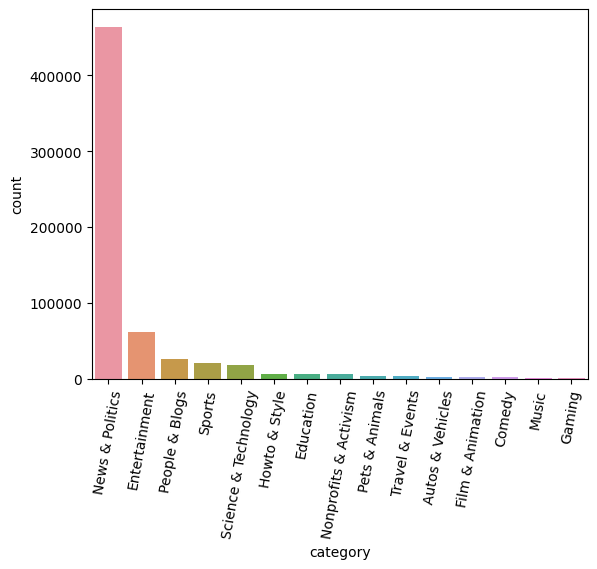

In [18]:
df_video_categories = pd.DataFrame(df_videos_raw.categories.value_counts())
df_video_categories["category"] = df_video_categories.index
df_video_categories.rename(dict(categories="count"), axis=1, inplace=True)

ax = sns.barplot(df_video_categories, x="category", y="count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

Let's look at what types of videos are left. As we see it is practically only New & Politics, which indicates that our matching generally worked.
After we manually review the matching of new outlets to channels we may consider dropping videos from other categories.

In [19]:
df_videos = df_videos_raw[df_videos_raw.categories == "News & Politics"]
print(f"From {len(df_videos_raw)} videos, {len(df_videos)} remain. We removed {(1-len(df_videos)/len(df_videos_raw))*100:.2f}%")

df_videos = pd.merge(df_videos, df_news[["channel_id", "channel_title", "bias"]], on="channel_id")

del df_videos_raw
df_videos.to_csv("data/df_videos.csv.gz", index=False, compression="infer")

From 623726 videos, 464172 remain. We removed 25.58%


### 1.6 Filter channels that don't have videos


In [20]:
channels_with_news = set(df_videos.channel_id.unique())
print("Even though there are", len(df_news), "channels in our dataset, only", len(channels_with_news), "of them have actually published any politics-related videos.")

Even though there are 176 channels in our dataset, only 158 of them have actually published any politics-related videos.


In [21]:
channels_no_videos = set(df_news.channel_id).difference(channels_with_news)

df_news[df_news.channel_id.isin(channels_no_videos)]

source_name source_type media_bias_rating  \
29             Common Sense  News Media            Center   
30                  Complex  News Media            Center   
37             Desiring God  News Media        Lean Right   
42                 ESPN.com  News Media         Lean Left   
60                      IVN  News Media            Center   
62            Jubilee Media  News Media            Center   
67                   Leafly  News Media              Left   
70             Live Science  News Media            Center   
78                 MIT News  News Media            Center   
79                     Mitú  News Media              Left   
106  Premier Christian News  News Media         Lean Left   
113           Revolver News  News Media             Right   
118     Scientific American  News Media         Lean Left   
127               The Blaze  News Media             Right   
143        The Minority Eye  News Media              Left   
146       The Onion (Humor)  News Media         Lean Left   
158                    Them  News Media         Lean Left   
164                 Variety  News Media            Center   

                             source_url                channel_id  \
29        https://www.commonsense.news/  UCkGxNMDRlhLmxvKL5RhvXHw   
30             https://www.complex.com/  UCE_--R1P5-kfBzHTca0dsnw   
37         https://www.desiringgod.org/  UCnrFlpro0xfYjz6s5Xa8WWw   
42                https://www.espn.com/  UCiWLfSweyRNmLpgEHekhoAg   
60                    http://www.ivn.us  UC_DuX83WnAB_iL3ub9wMJPg   
62        https://www.jubileemedia.com/  UCJjSDX-jUChzOEyok9XYRJQ   
67              https://www.leafly.com/  UCqVnkns6Gf3W7J9zWZE4EqA   
70         https://www.livescience.com/  UCOTA1_oiKnz8po1Rm3nDJPg   
78                  http://news.mit.edu  UCFe-pfe0a9bDvWy74Jd7vFg   
79               https://wearemitu.com/  UCaemYNcQbzuQKJu6BnxgmxA   
106      https://premierchristian.news/  UCGShEFPwwFDaJem_0kjH4Pw   
113          https://www.revolver.news/  UC_tKHpo6xYpwdIRC4uotmuQ   
118  http://www.scientificamerican.com/  UC_xYMXx_-mAzheKyEtwtCAQ   
127            http://www.theblaze.com/  UCscDWYhNER2NvEVKfL0aYwA   
143         https://theminorityeye.com/  UCYd0us2OtW4d4-1cfpT2ktw   
146           https://www.theonion.com/  UCfAOh2t5DpxVrgS9NQKjC7A   
158                https://www.them.us/  UCZEL_lFVOcFVlmjhguk0IxQ   
164                https://variety.com/  UCgRQHK8Ttr1j9xCEpCAlgbQ   

                                   channel_title  \
29                                  Common Sense   
30                                       Complex   
37                                  Desiring God   
42                                          ESPN   
60                                           IVN   
62                                       Jubilee   
67                                        Leafly   
70                                   LiveScience   
78   Massachusetts Institute of Technology (MIT)   
79                                          Mitú   
106                            Premier On Demand   
113                                     REVOLVER   
118                          Scientific American   
127                                    The Blaze   
143                              The Norris Nuts   
146                                    The Onion   
158                                         them   
164                                      Variety   

                                   channel_description            category_cc  \
29   The creator of great lyrics videos, and other ...          Entertainment   
30   COMPLEX is a community of creators and curator...          Entertainment   
37   Most people in the world have no experience of...  Nonprofits & Activism   
42   The official YouTube Page of ESPN Features up-...                 Sports   
60                                1997. Homestead, FL.                  Music   
62    Provoke understanding & create human connection.          Enter

All these channels don't actually appear with any videos. We will therefore remove them from our dataframe `df_news`.

In [22]:
df_news = df_news[df_news.channel_id.isin(channels_with_news)]
df_news.to_csv("data/df_news.csv.gz", index=False)

## 2 General Data Exploration

### 2.1 Some Basic Metrics

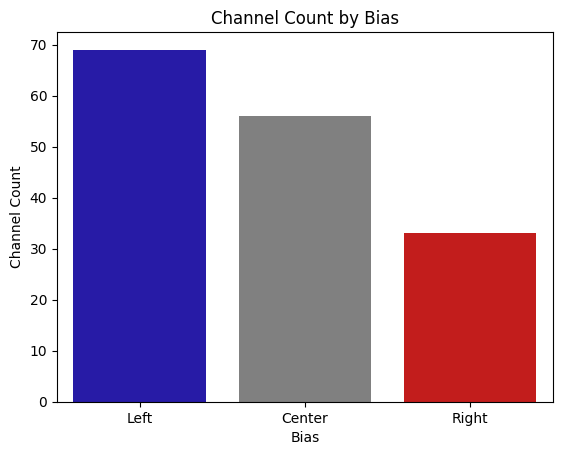

In [75]:
df_bias = pd.DataFrame(df_news.bias.value_counts()).rename(dict(bias="count"), axis=1)
df_bias["bias"] = df_bias.index

plt.title("Channel Count by Bias")

ax = sns.barplot(df_bias, x="bias", y="count", palette=BIAS_COLORS)

ax.set_xlabel("Bias")
ax.set_ylabel("Channel Count")

plt.savefig("./assets/bars_channel_count_by_bias.png", dpi=500)

So there more channels on the left side of the spectrum than the right. Could this lead to a bias in our data?

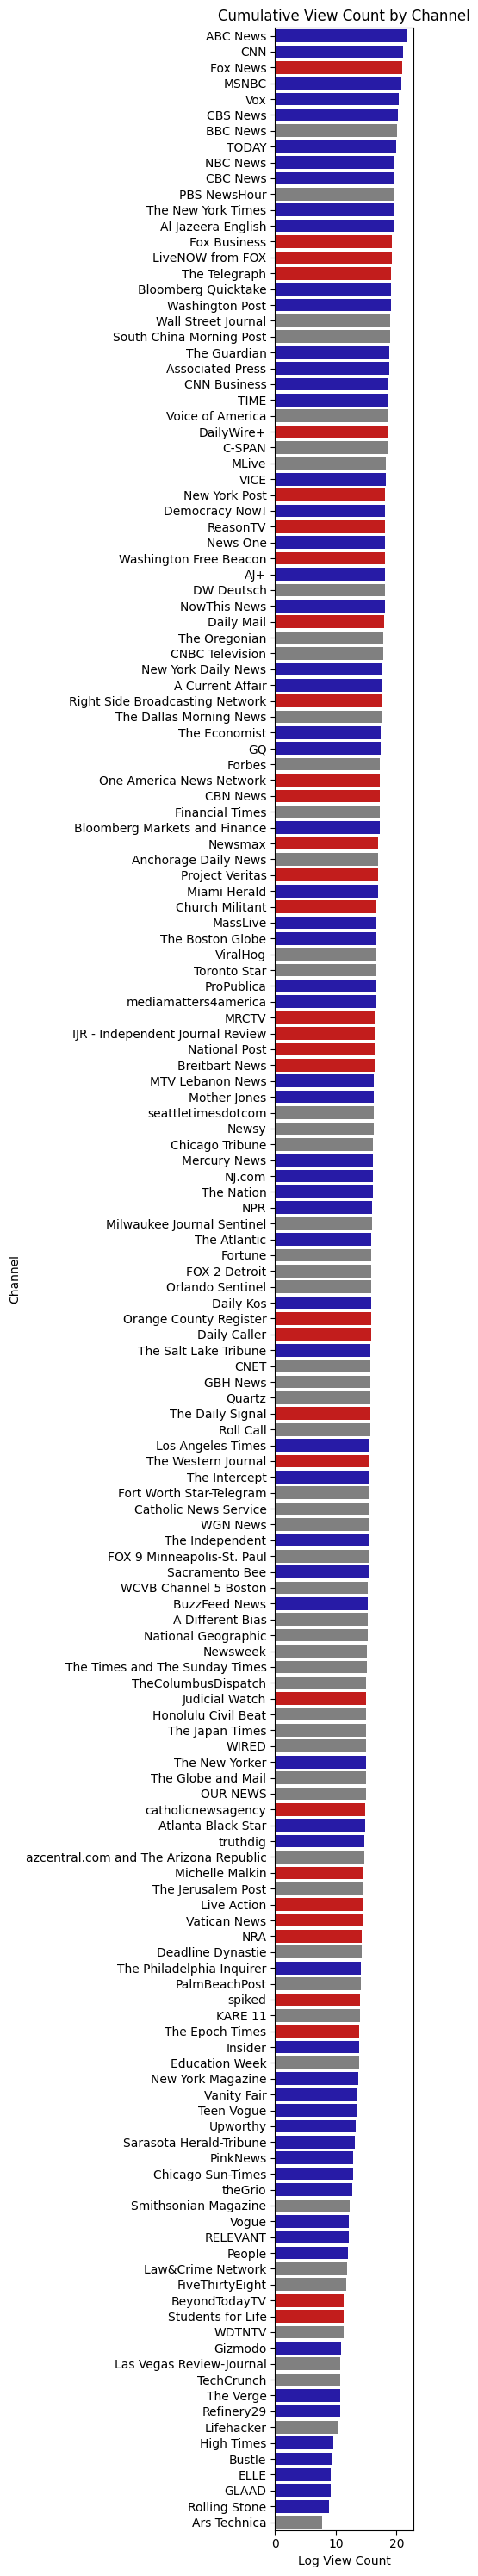

In [86]:
df_views_per_channel = df_videos.groupby("channel_id")["view_count"].sum().reset_index()
df_views_per_channel = pd.merge(df_views_per_channel, df_news[["channel_id", "channel_title", "bias"]])
df_views_per_channel["color"] = [BIAS_COLORS[bias] for bias in df_views_per_channel.bias]
df_views_per_channel["log_view_count"] = np.log(df_views_per_channel.view_count)
df_views_per_channel.sort_values("log_view_count", ascending=False, inplace=True)

plt.figure(figsize=(5,30))

plt.title("Cumulative View Count by Channel")

ax = sns.barplot(df_views_per_channel, y="channel_title", x="log_view_count", palette=df_views_per_channel.color)

ax.set_xlabel("Log View Count")
ax.set_ylabel("Channel")
plt.tight_layout()
plt.savefig("./assets/bars_view_count_by_channel.png", dpi=400, bbox_inches = "tight")

We do have the measure of subscriber count, but view count more accurately represents the size of the audience reached.

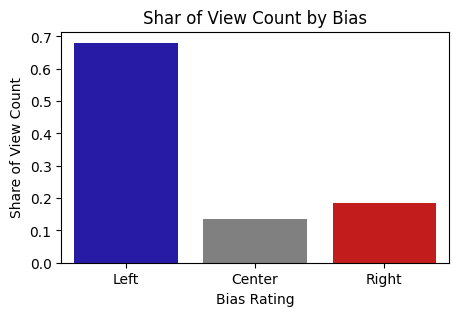

In [76]:
df_view_count_by_bias = df_videos.groupby("bias")["view_count"].sum().reset_index()
df_view_count_by_bias["color"] = [BIAS_COLORS[bias] for bias in df_view_count_by_bias.bias]
df_view_count_by_bias.bias = df_view_count_by_bias.bias.astype(pd.api.types.CategoricalDtype(list(BIAS_COLORS)))
df_view_count_by_bias.sort_values("bias", inplace=True)

df_view_count_by_bias["view_count_share"] = df_view_count_by_bias.view_count / df_view_count_by_bias.view_count.sum()

plt.figure(figsize=(5, 3))

plt.title("Share of View Count by Bias")

ax = sns.barplot(df_view_count_by_bias,
                 x="bias", y="view_count_share",
                 palette=df_view_count_by_bias.color,
                 )

ax.set_xlabel("Bias Rating")
ax.set_ylabel("Share of View Count")

plt.savefig("./assets/bars_share_of_view_count_by_bias.png", dpi=500)

There actually is _way_ more audience on the left side of the political spectrum on YouTube!

### 2.2 Get comments from those videos
Filter comments of all relevant videos

In [27]:
# for now we are only interested in the video's ids
video_ids = set(df_videos.display_id)

# catch raw comments in this data structure
# we could optimize for low-memory machines by writing record-for-record to file directly at a later point
comments = []

i = 0
with pd.read_csv("data/youtube_comments.tsv.gz", sep="\t", chunksize=1000000) as df_stream:
  for df_comments_chunk in df_stream:
    i += 1

    # filter comments for the subset of videos we are interested in
    comments.append(df_comments_chunk[df_comments_chunk.video_id.isin(video_ids)])

df_comments = pd.concat(comments)
del comments
df_comments.to_csv("data/df_comments.csv.gz", index=False, compression="infer")

df_comments.head()

/tmp/ipykernel_216399/758681105.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_comments_chunk in df_stream:
/tmp/ipykernel_216399/758681105.py:10: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_comments_chunk in df_stream:


author     video_id likes replies
1305      30  HqBtIWFW-0k     2       2
1306      30  HqBtIWFW-0k     0       0
2082      97  n2ZEbfwfxKs     0       0
2090      97  n2ZEbfwfxKs     0       0
3899     269  anah_4blbyU     0       0

Next, we link each video with its channel, as ultimately, we aggregate by channel and not by video.

### 2.3 Find common commenters
We create an edgelist of a graph. Each channel is a node. The edges are common commenters between videos of the corresponding channels. The edge weight is the count of commentors that commented on videos of both channels, i.e. the strength of the connection between two channels.

In [28]:
def get_combinations_of_videos_per_commenter(commenter_group, c):
  """Computes pairwise combinations of channels for a given commenter
  """

  # Currently the weight is not increased if a user comments under multiple videos of both channels
  # We will review this, as it influences the final weight of the edges in our graph
  channels = commenter_group.channel_id.unique()

  # this only makes sense if a user commented under more than one video
  if len(channels) == 1:
    return

  channels.sort()

  # Get pairwise combinations  
  combs = combinations(channels, 2)
  for comb in combs:

    if not comb in c:
      c[comb] = 0

    c[comb] += 1

def get_edgelist_from_common_commenters(df_videos, df_comments):
  """Computes and edgelist for a graph where channels are nodes,
  edges are common commenters, and edge weights are the count of common commenters
  """
  # This dictionary maps from combination of channels to a count of commenters
  # We use an ordered tuple of channel IDs as key
  c = dict()

  df_comments_channels = pd.merge(df_videos[["channel_id", "display_id"]], df_comments, left_on="display_id", right_on="video_id")

  # aggregate comment data by comment author
  df_comments_channels_grouped = df_comments_channels.groupby("author")

  del df_comments_channels

  # for each commenter update the edgelist and for any connection increase the weights
  df_comments_channels_grouped.apply(lambda commenter_group: get_combinations_of_videos_per_commenter(commenter_group, c))

  del df_comments_channels_grouped

  connections = [k+(v,) for k, v in c.items()]

  # name columns so gephi can understand (Source and Target even though it is an undirected graph)
  df_graph = pd.DataFrame(connections, columns=["channel1", "channel2", "weight"])

  return df_graph

In [29]:
df_graph = get_edgelist_from_common_commenters(df_videos, df_comments)
df_graph.to_csv("data/df_graph.csv.gz", index=False, compression="infer")

## 3 Network Analysis

In [30]:
df_channels = pd.read_csv("data/df_news.csv.gz")
df_graph = pd.read_csv("data/df_graph.csv.gz")
df_news = pd.read_csv("data/df_news.csv.gz")

In [31]:
def filter_nodes_for_edgelist(df_edgelist, df_nodelist):
  """Makes sure there are only edges in df_edgelist that connect nodes that are in df_nodelist and vice-versa
  """
  # remove unused nodes
  ch1 = set(df_edgelist.channel1.unique())
  ch2 = set(df_edgelist.channel2.unique())
  connected_channels = ch1.union(ch2)

  all_channels = set(df_nodelist.channel_id)
  unconnected_channels = all_channels.difference(connected_channels)

  df_nodelist = df_nodelist.copy()[df_nodelist.channel_id.isin(connected_channels)]

  removed_nodes = df_nodelist[df_nodelist.channel_id.isin(unconnected_channels)]

  # remove unused edges so we don't accidentally include nodes we don't want
  df_edgelist = df_edgelist[df_edgelist.channel1.isin(df_nodelist.channel_id) & df_edgelist.channel2.isin(df_nodelist.channel_id)].copy()

  return df_edgelist, df_nodelist

In [32]:
def avg_color(c1: str, c2: str) -> str:
  """Computes the average color value between two colors
  """
  c1 = Color(c1)
  c2 = Color(c2)
  c3 = Color()

  c3.set_red((c1.get_red() + c2.get_red()) / 2)
  c3.set_green((c1.get_green() + c2.get_green()) / 2)
  c3.set_blue((c1.get_blue() + c2.get_blue()) / 2)

  return c3.get_hex()

In [33]:
def calculate_weighted_degree_and_homophily(G):
  """Computs weighted degree and weighted homophily for each node in G

  We define weighted degree as the sum of all edge weights

  We define weighted homophily by the fraction of the sum of edge weights of neighbors of the same class over the weighted degree (sum of all edge weights)
  """
  for node in G:
    weighted_degree = 0
    weighted_homophily = 0

    # for each node also iterate over the neighbors
    for neighbor in G.neighbors(node):
      edge_weight = G.get_edge_data(node, neighbor)["weight"]

      # add influence of this neighbor on weighted degree
      weighted_degree += edge_weight

      # add to homophily measure if node is of the same class
      bias_node = G.nodes[node]["bias"]
      bias_neighbor = G.nodes[neighbor]["bias"]
      if bias_node == bias_neighbor:
        weighted_homophily += edge_weight

    weighted_homophily = weighted_homophily / weighted_degree

    nx.set_node_attributes(G, {node: weighted_degree}, "weighted_degree")
    nx.set_node_attributes(G, {node: weighted_homophily}, "weighted_homophily")

  return G

In [34]:
def construct_graph(df_edgelist, df_nodelist):
  """Constructs a networkx graph from an edgelist and a nodelist
  """

  df_edgelist, df_nodelist = filter_nodes_for_edgelist(df_edgelist, df_nodelist)

  G = nx.Graph()

  # add all nodes
  for _, channel in df_nodelist.iterrows():
    G.add_node(
      channel.channel_id,
      title=channel.channel_title,
      color=channel.color,
      bias=channel.bias,
      view_count=channel.view_count,
    )
  
  df_nodelist.index = df_nodelist.channel_id

  # add all edges including the weights
  for idx, edge in df_edgelist.iterrows():
    c1 = df_nodelist.at[edge.channel1, "color"]
    c2 = df_nodelist.at[edge.channel2, "color"]

    # set edge color as average color of the nodes it connects
    c = avg_color(c1, c2)

    G.add_edge(edge.channel1, edge.channel2, weight=edge.weight, color=c)
  
  return calculate_weighted_degree_and_homophily(G)

In [82]:
def draw_graph(G, title="", plot_title="full"):
  """Visualizes the networkx graph
  """
  ax = plt.figure(figsize=(16, 16))

  pos = nx.spring_layout(G,
    seed=8,
    k=7,
    scale=1,
    weight="log_weight",
    )

  # draw label slightly above node
  label_pos = {node: (x, y+0.02) for (node, (x, y)) in pos.items()}
  label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
  nx.draw_networkx_labels(G,
    pos=label_pos,
    labels=nx.get_node_attributes(G, "title"),
    font_size=6,
    bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.6),
    )

  # do some transformation on node size
  size_range = 200
  min_size = 3
  node_sizes = np.array(list(nx.get_node_attributes(G, "view_count").values()))
  node_sizes = min_size + size_range * (node_sizes - np.min(node_sizes)) / (np.max(node_sizes) - np.min(node_sizes))
  nx.draw_networkx_nodes(
    G,
    pos=pos,
    node_size=node_sizes,
    node_color=list(nx.get_node_attributes(G, "color").values()),
    )

  # do some transformation on edge widths
  min_width = 0
  width_range = 2.5
  column = list(nx.get_edge_attributes(G, "weight").values())
  edge_width = min_width + width_range * MinMaxScaler().fit_transform(np.array(column).reshape(-1, 1)).flatten()
  # # column = 
  # edge_width = min_width + width_range * np.array(list(nx.get_edge_attributes(G, "weight").values()))
  nx.draw_networkx_edges(
    G,
    pos=pos,
    width=edge_width,
    alpha=0.7,
    edge_color=list(nx.get_edge_attributes(G, "color").values())
  )


  plt.title(title)
  plt.tight_layout()

  plt.savefig(f"./assets/graph_channel_{plot_title}.png", dpi=400)

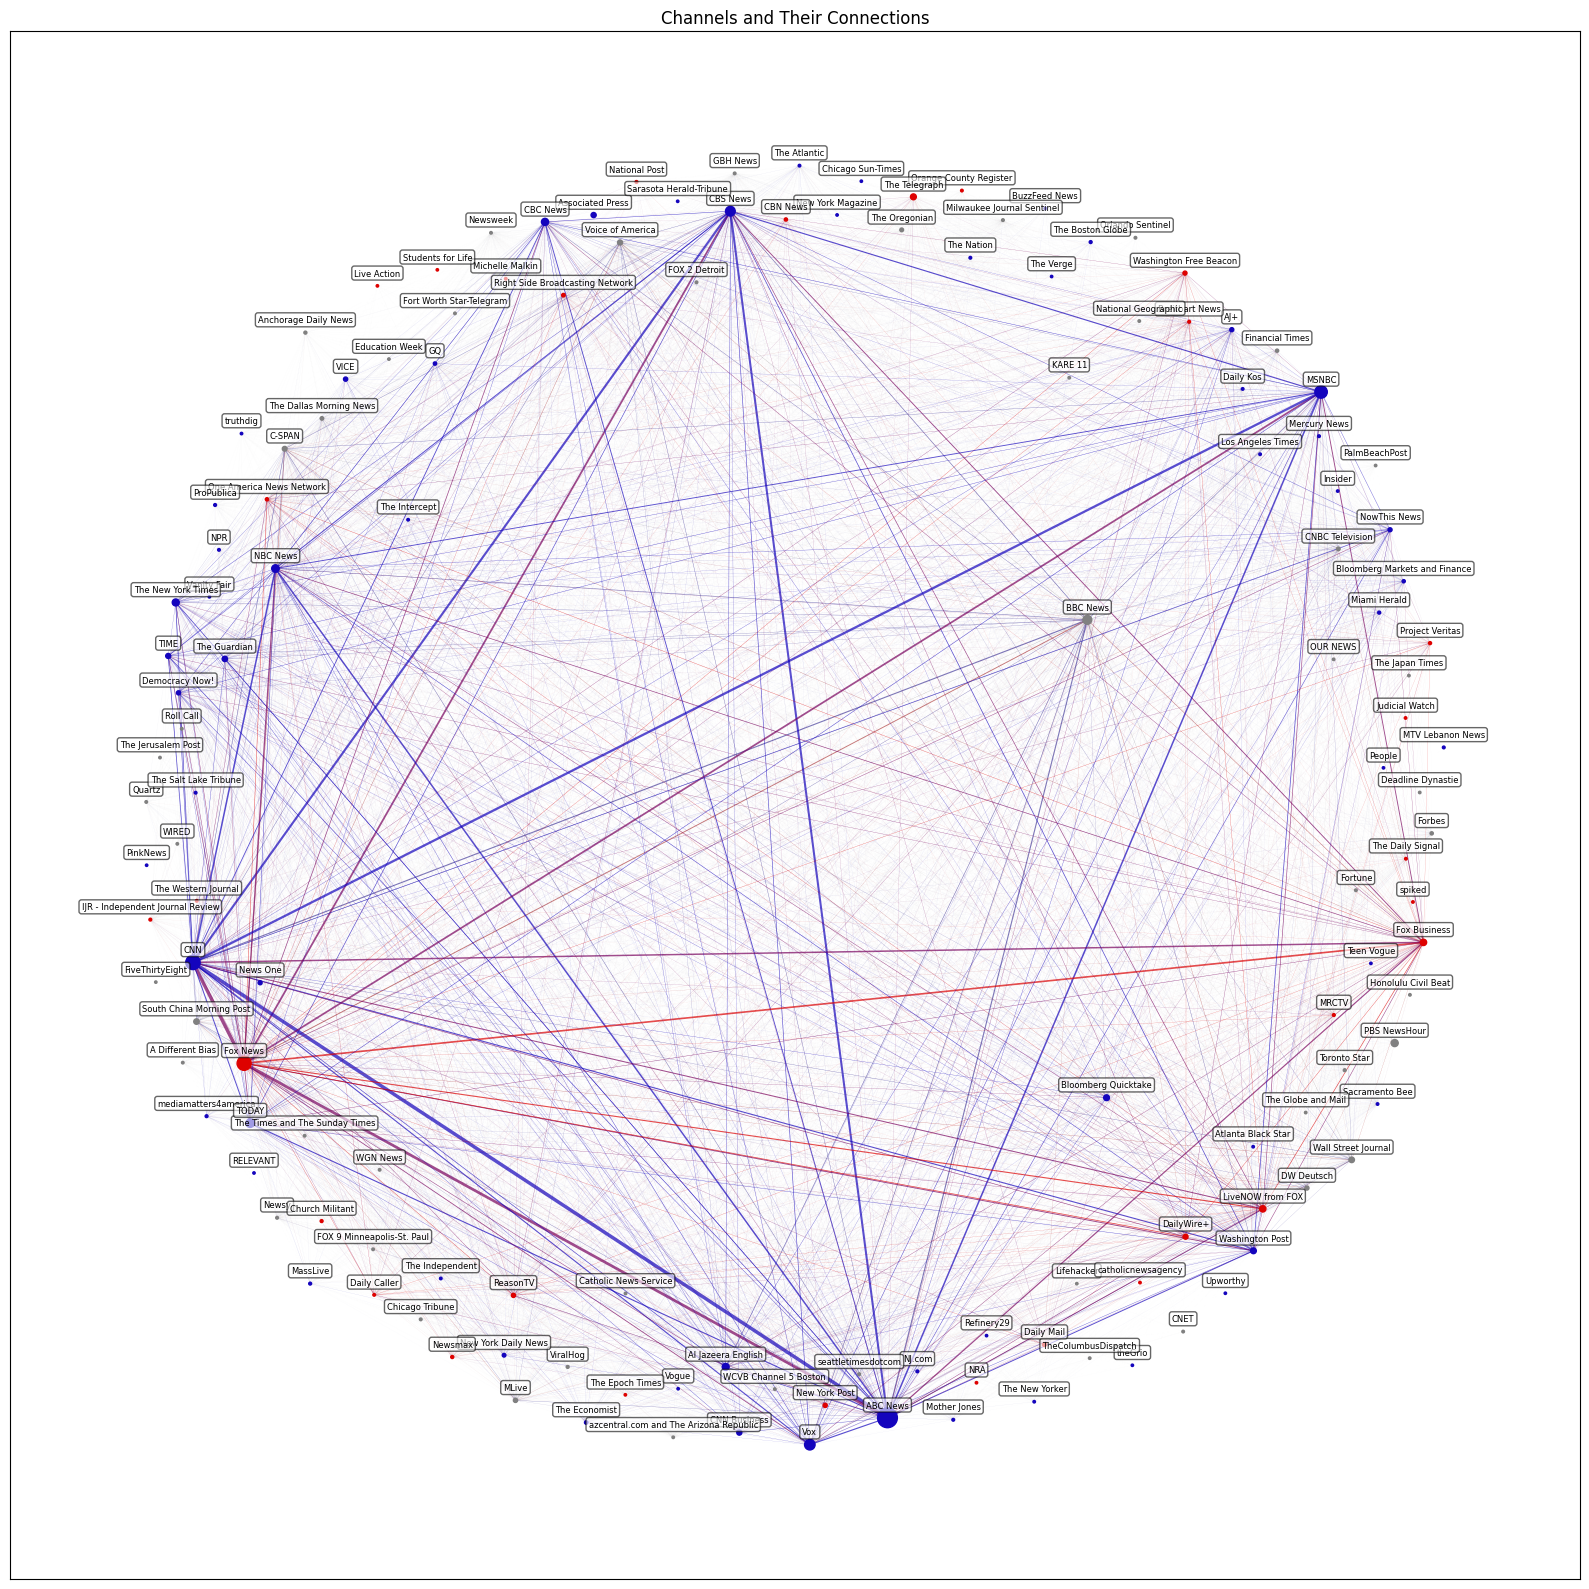

In [83]:
df_views_per_channel = pd.merge(
  df_videos.groupby("channel_id")["view_count"].sum().reset_index(),
  df_news[["channel_id", "channel_title", "bias", "color"]]
)

G = construct_graph(df_nodelist=df_views_per_channel, df_edgelist=df_graph)

draw_graph(G, "Channels and Their Connections")

### 3.1 Analyze the network

Visually the graph is quite dense and quite blue. Let's investigate.

In [37]:
nx.density(G)

0.8911197682549196

In [38]:
nx.attribute_assortativity_coefficient(G, 'bias')

-0.005615713592416709

So homophily is non-existant - there is no systematic correlation of similar bias going together.

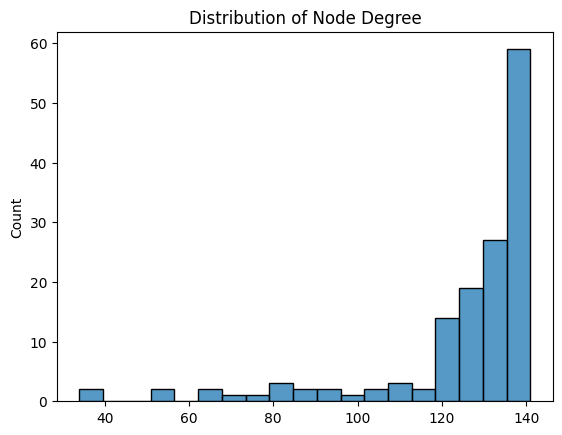

In [88]:
degrees = [deg[1] for deg in list(G.degree)]

ax = sns.histplot(degrees)

plt.title("Distribution of Node Degree")

plt.savefig("./assets/hist_node_degree.png", dpi=400)

This density is super high! Almost all possible connections exist. Therefore, we cannot find meaningful clusters. Let's take a look at the strength of the connections.

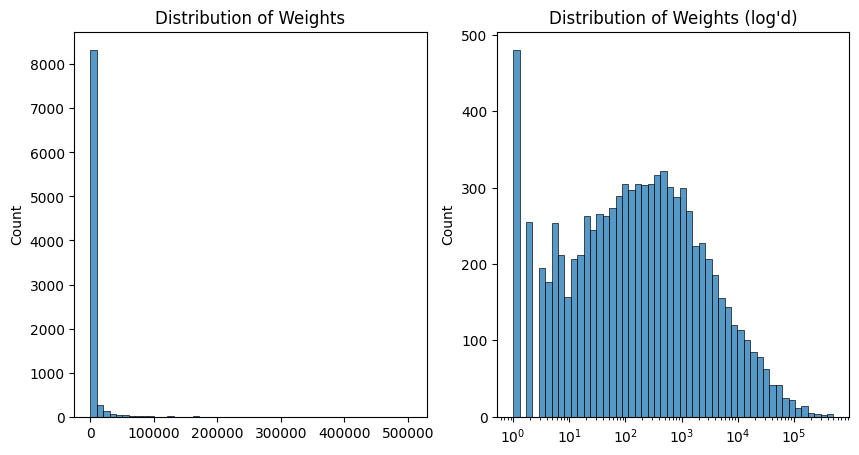

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

weights = np.array(list(nx.get_edge_attributes(G, "weight").values()))

sns.histplot(weights, bins=50, log_scale=False, ax=axes[0]).set_title("Distribution of Weights")
sns.histplot(weights, bins=50, log_scale=True, ax=axes[1]).set_title("Distribution of Weights (log'd)")

plt.savefig("./assets/hists_weight_distribution.png", dpi=400)

In [102]:
from collections import OrderedDict

weights = nx.get_edge_attributes(G, "weight")
df_news[df_news.channel_id.isin(min(weights))]

source_name source_type media_bias_rating  \
91   Orlando Sentinel  News Media            Center   
119     The Economist  News Media         Lean Left   

                           source_url                channel_id  \
91   https://www.orlandosentinel.com/  UC-MCjIJ5Wo61YyzJjC7Mh7w   
119         http://www.economist.com/  UC0p5jTq6Xx_DosDFxVXnWaQ   

        channel_title                                channel_description  \
91   Orlando Sentinel  Your online news and information resource for ...   
119     The Economist  The Economist videos give authoritative insigh...   

         category_cc   join_date  subscribers_cc  videos_cc  \
91   News & Politics  2006-08-29           20700       2248   
119  News & Politics  2009-03-23          999000       1812   

     subscriber_rank_sb  weights    bias    color  
91             536320.0   9.0450  Center  #808080  
119             13820.0   2.8075    Left  #1404bd

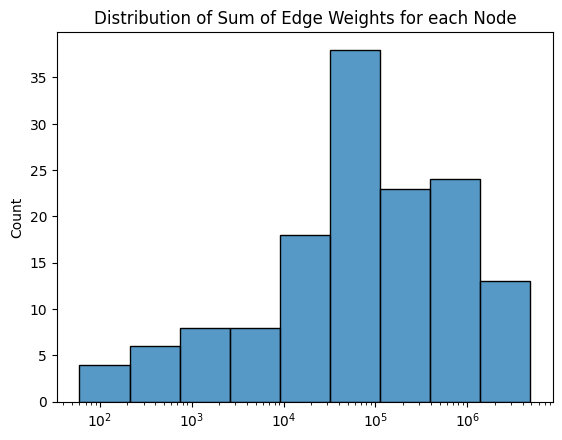

In [103]:
weighted_degree = np.array(list(nx.get_node_attributes(G, "weighted_degree").values()))

df_node_weighted_degree = sns.histplot(weighted_degree, log_scale=True)

plt.title("Distribution of Sum of Edge Weights for each Node")

plt.savefig("./assets/bars_edge_weights.png", dpi=500)

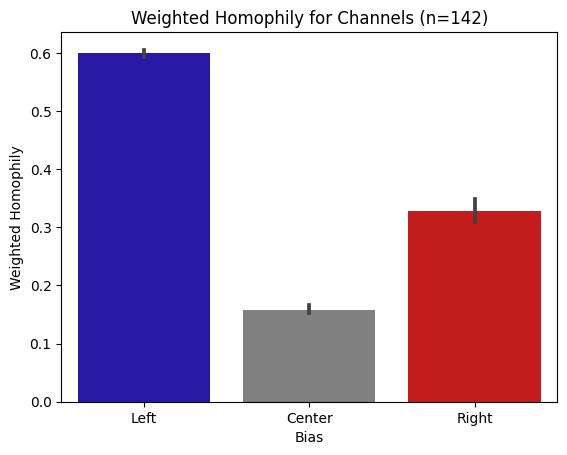

In [122]:
df_bias_homophily = pd.DataFrame([(data["weighted_homophily"], data["bias"]) for node, data in G.nodes().data()], columns=["weighted_homophily", "bias"])

ax = sns.barplot(df_bias_homophily, x="bias", y="weighted_homophily", palette=BIAS_COLORS, order=BIAS_COLORS)

ax.set_xlabel("Bias")
ax.set_ylabel("Weighted Homophily")

plt.title(f"Weighted Homophily for Channels (n={len(df_bias_homophily)})")

plt.savefig("./assets/bars_weighted_homophily.png", dpi=500)

This suggests that on the left, homophily is larger, i.e. the connection between left-biased videos is stronger than on the right. However this looks awfully similar to  the graph of cumulative view counts by bias.

### 3.2 Channel Matching

In [43]:
df_news.bias.value_counts()

Left      69
Center    56
Right     33
Name: bias, dtype: int64

There are more than twice as many reft-biased channels than right-biased channels.

We consider the following features for propensity score matching

- subscribers
- view count
- video count
- comment count

In [44]:
df_news_subset = pd.merge(df_news, df_views_per_channel[["channel_id", "view_count"]], on="channel_id")

df_comments_channels = pd.read_csv("data/df_comments_channels.csv.gz")

df_comments_per_channel = df_comments_channels.groupby("channel_id").count()["video_id"].reset_index().rename(dict(video_id="comment_count"), axis=1)

df_news_subset = pd.merge(df_news_subset, df_comments_per_channel, on="channel_id")

Text(0.5, 1.0, 'Distribution of Comment Count (log-log)')

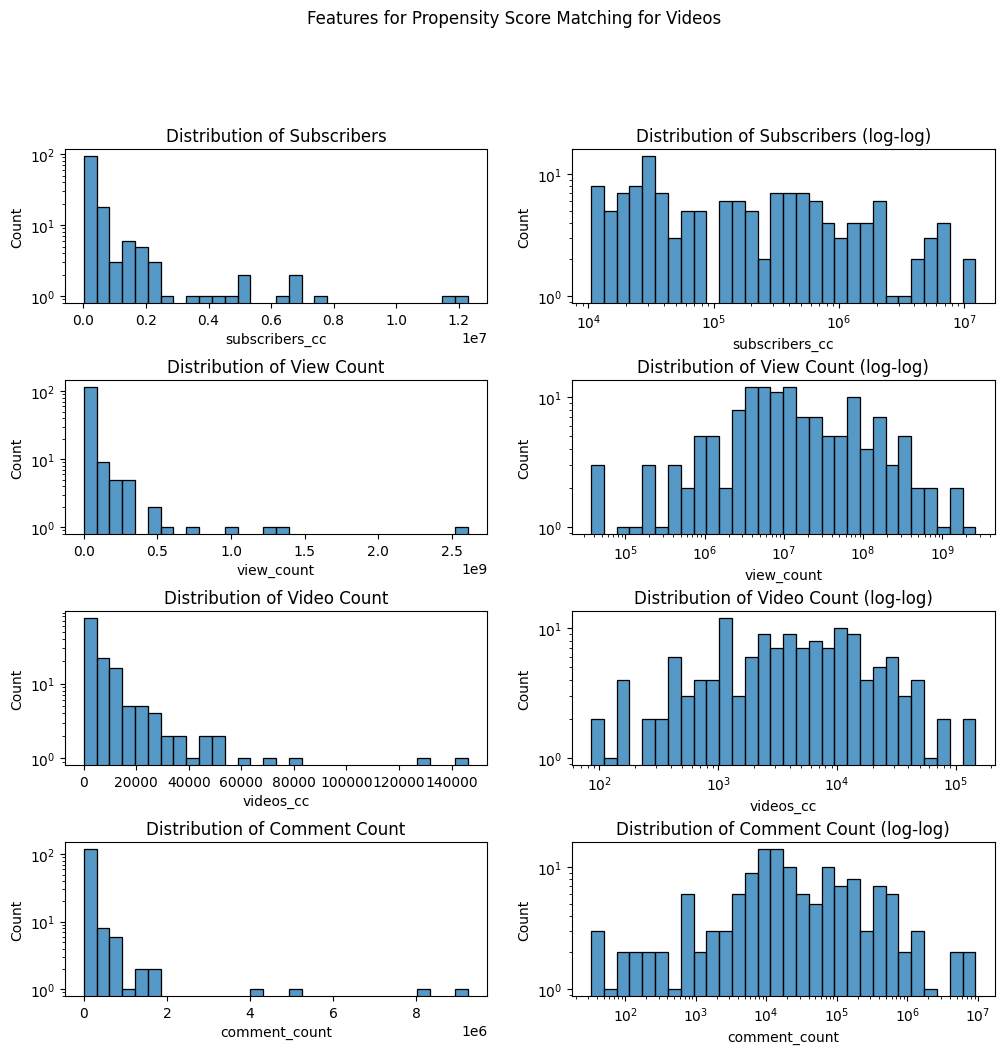

In [45]:
fig = plt.figure(figsize=(12, 14))

plt.suptitle("Features for Propensity Score Matching for Videos")

gs = plt.GridSpec(5, 2, figure=fig, hspace=0.5)

# create sub plots as grid
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])

sns.histplot(df_news_subset, x="subscribers_cc", bins=30, log_scale=[False, True], ax=ax1).set_title("Distribution of Subscribers")
sns.histplot(df_news_subset, x="subscribers_cc", bins=30, log_scale=[True, True], ax=ax2).set_title("Distribution of Subscribers (log-log)")

sns.histplot(df_news_subset, x="view_count", bins=30, log_scale=[False, True], ax=ax3).set_title("Distribution of View Count")
sns.histplot(df_news_subset, x="view_count", bins=30, log_scale=[True, True], ax=ax4).set_title("Distribution of View Count (log-log)")

sns.histplot(df_news_subset, x="videos_cc", bins=30, log_scale=[False, True], ax=ax5).set_title("Distribution of Video Count")
sns.histplot(df_news_subset, x="videos_cc", bins=30, log_scale=[True, True], ax=ax6).set_title("Distribution of Video Count (log-log)")

sns.histplot(df_news_subset, x="comment_count", bins=30, log_scale=[False, True], ax=ax7).set_title("Distribution of Comment Count")
sns.histplot(df_news_subset, x="comment_count", bins=30, log_scale=[True, True], ax=ax8).set_title("Distribution of Comment Count (log-log)")

We therefore apply the following transformations:

We log-transform the counts for better visibility. Features that show are more or less normal distribution can be standardized. For equal distributions a min-max scaling shall be used.

- subsciber count -> log and min-max scale, as there is no recognizable normal-ish distribution
- the rest -> log and standardize, as there is a recognizable normal-ish distribution

In [46]:
def scale_column_standard(column: pd.Series):
  return StandardScaler().fit_transform(np.array(column).reshape(-1, 1))

def scale_column_min_max(column: pd.Series):
  return MinMaxScaler().fit_transform(np.array(column).reshape(-1, 1))


# - subscribers
# log subscribers -> min-max
df_news_subset.subscribers_cc = scale_column_min_max(np.log(df_news_subset.subscribers_cc))

# - view count
# log view count -> standard
df_news_subset.view_count = scale_column_standard(np.log(df_news_subset.view_count))

# - video count
# log video count -> standard
df_news_subset.videos_cc = scale_column_standard(np.log(df_news_subset.videos_cc))

# - comment count
# log comment count -> standard
df_news_subset.comment_count = scale_column_standard(np.log(df_news_subset.comment_count))

In [47]:
# we care about channels on the left and right in particular for the analyses building on the matched dataset
df_news_subset = df_news_subset[df_news_subset.bias != "Center"].copy()

# target variable
df_news_subset.bias = [1 if bias == "Right" else 0 for bias in df_news_subset.bias]

mod = smf.logit(data=df_news_subset[["bias", "subscribers_cc", "view_count", "videos_cc", "comment_count"]], formula='bias ~ subscribers_cc + view_count + videos_cc + comment_count')
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.568529
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   bias   No. Observations:                   92
Model:                          Logit   Df Residuals:                       87
Method:                           MLE   Df Model:                            4
Date:                Sat, 17 Dec 2022   Pseudo R-squ.:                  0.1103
Time:                        09:06:16   Log-Likelihood:                -52.305
converged:                       True   LL-Null:                       -58.788
Covariance Type:            nonrobust   LLR p-value:                   0.01144
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4851      0.567      0.856      0.392      -0.625       1.596
subscribers_cc    -3.4525      1.388     -2.488      0.013      -6.172      -0.733
view_count        -1.0590      0.823     -1.287      0.198      -2.672       0.554
videos_cc          0.0327      0.287      0.114      0.909      -0.531       0.596
comment_count      1.7745      0.846      2.097      0.036       0.116       3.433
==================================================================================
"""

We chose to omit the videos_cc, due to low coefficient and extremely high p-value

In [48]:
mod = smf.logit(data=df_news_subset[["bias", "subscribers_cc", "view_count", "comment_count"]], formula='bias ~ subscribers_cc + view_count + comment_count')
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.568599
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   bias   No. Observations:                   92
Model:                          Logit   Df Residuals:                       88
Method:                           MLE   Df Model:                            3
Date:                Sat, 17 Dec 2022   Pseudo R-squ.:                  0.1102
Time:                        09:06:16   Log-Likelihood:                -52.311
converged:                       True   LL-Null:                       -58.788
Covariance Type:            nonrobust   LLR p-value:                  0.004739
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4671      0.544      0.859      0.391      -0.599       1.533
subscribers_cc    -3.4105      1.336     -2.554      0.011      -6.028      -0.793
view_count        -1.0213      0.753     -1.357      0.175      -2.497       0.454
comment_count      1.7495      0.816      2.143      0.032       0.150       3.349
==================================================================================
"""

In [49]:
# calculate propensity score
df_news_subset["score"] = res.predict()

df_news_subset = df_news_subset[["channel_id", "score", "bias"]]

In [50]:
treat = df_news_subset[df_news_subset.bias == 1].reset_index().drop("index", axis=1).copy().reset_index()
control = df_news_subset[df_news_subset.bias == 0].reset_index().drop("index", axis=1).copy().reset_index()

print(f"The treatment dataset (right) has fewer datapoints than control. (treat: {len(treat)} vs control: {len(control)}).")

matched_controls = set()

# match one left channel for each right channel
for score in treat.score:
  control_scores = np.array(control.score)

  # get id closest score
  idx = (np.abs(control_scores - score)).argmin()
  # get this score
  closest = control.iloc[idx,:]

  # drop it from dataframe so it can't be matched again
  control = control[control.channel_id != closest.channel_id]

  matched_controls.add(closest.channel_id)

df_news_matched = df_news[(df_news.channel_id.isin(matched_controls)) | (df_news.channel_id.isin(treat.channel_id))].copy()
df_news_matched.to_csv("data/df_news_matched.csv.gz", index=False)

print(f"The matched dataset comprises n={len(df_news_matched)}")

The treatment dataset (right) has fewer datapoints than control. (treat: 31 vs control: 61).
The matched dataset comprises n=62


We therefore match a control to each treatment datapoint.


### 3.3 Some more graph analysis
on the matched dataset

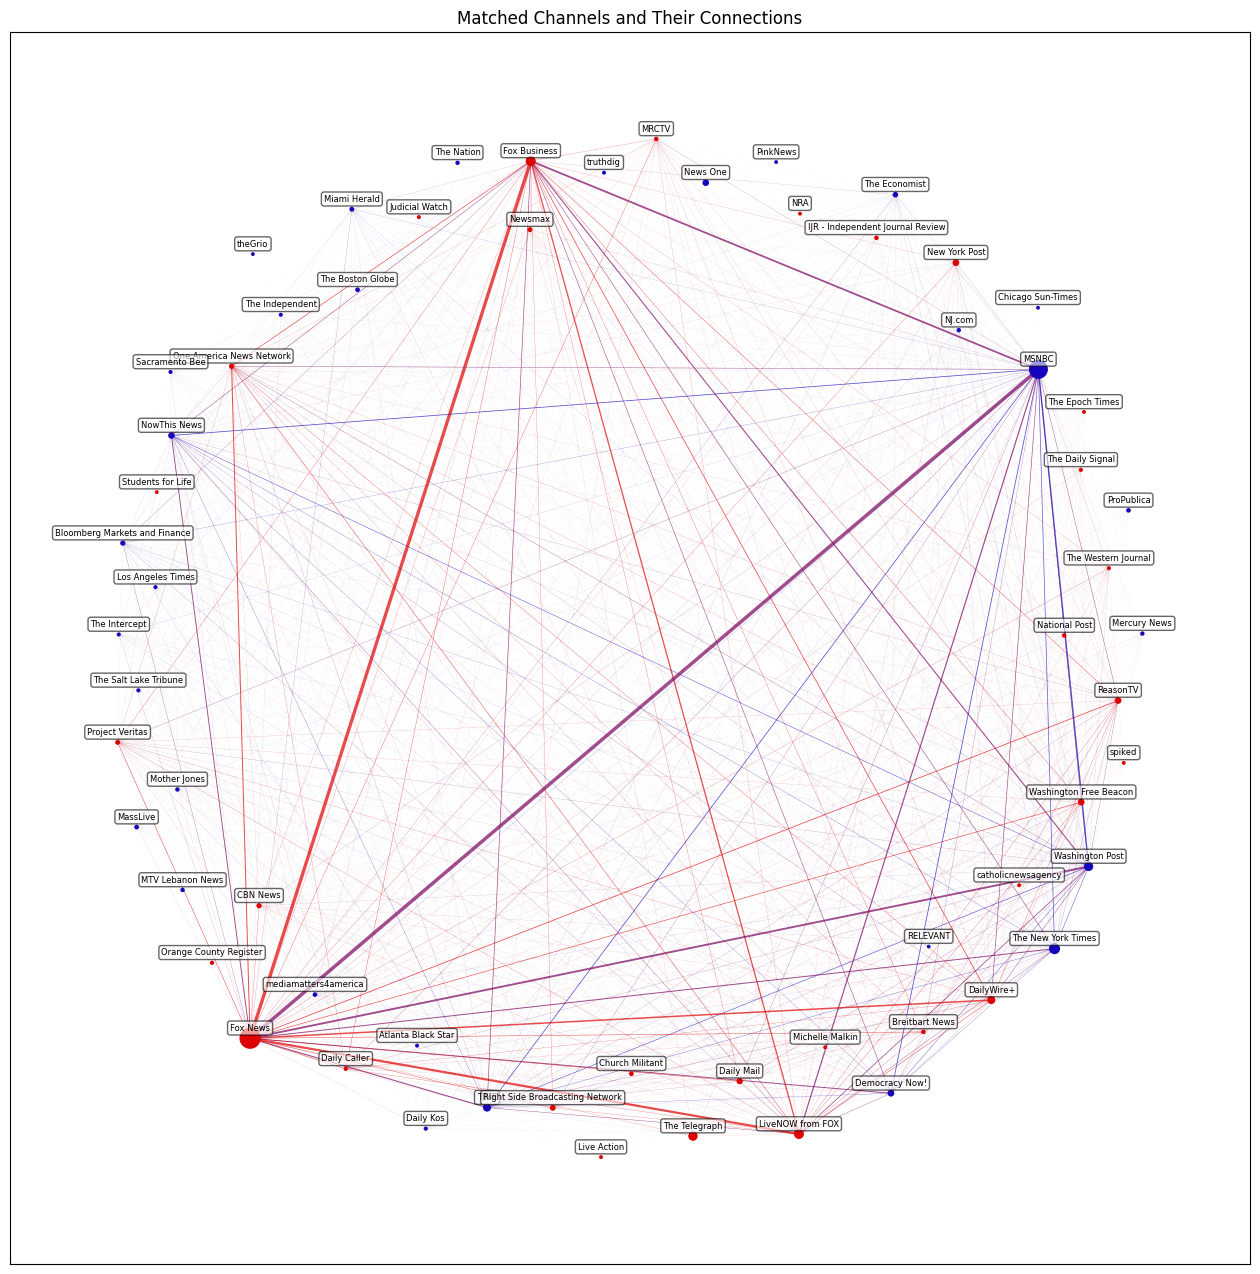

In [51]:
df_views_per_channel = pd.merge(
  df_videos.groupby("channel_id")["view_count"].sum().reset_index(),
  df_news_matched[["channel_id", "channel_title", "bias", "color"]]
)

G_matched = construct_graph(df_nodelist=df_views_per_channel, df_edgelist=df_graph)
draw_graph(G_matched, "Matched Channels and Their Connections", "matched")

In [52]:
nx.density(G_matched)

0.9487043892120571

Text(0.5, 1.0, 'Distribution of Node Degree')

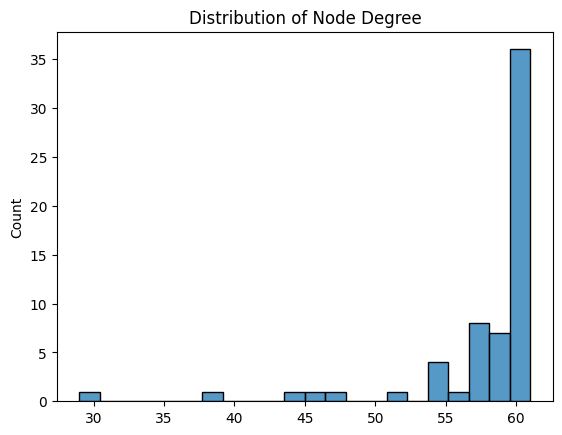

In [53]:
degrees = [deg[1] for deg in list(G_matched.degree)]

ax = sns.histplot(degrees)

plt.title("Distribution of Node Degree")

This density is super high! Almost all possible connections exist. Therefore, we cannot find meaningful clusters. Let's take a look at the strength of the connections.

Text(0.5, 1.0, 'Distribution of weights (log weight)')

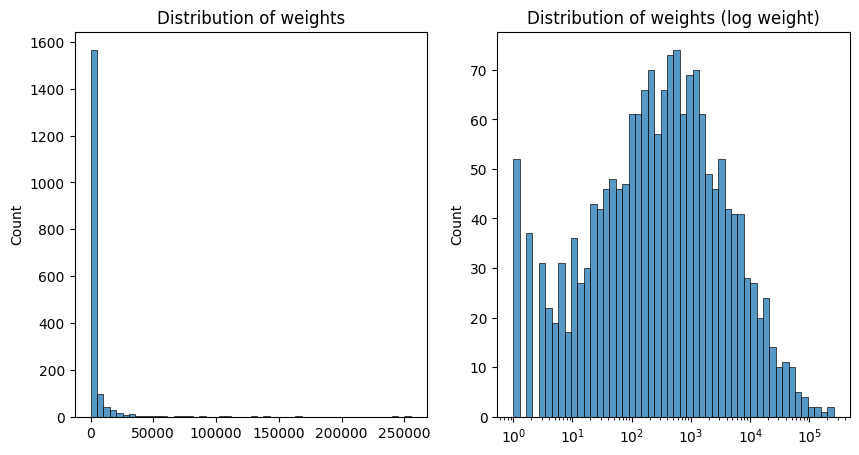

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

weights = np.array(list(nx.get_edge_attributes(G_matched, "weight").values()))

sns.histplot(weights, bins=50, log_scale=False, ax=axes[0]).set_title("Distribution of weights")
sns.histplot(weights, bins=50, log_scale=True, ax=axes[1]).set_title("Distribution of weights (log weight)")

Text(0.5, 1.0, 'Distribution of Sum of Edge Weights for each Node')

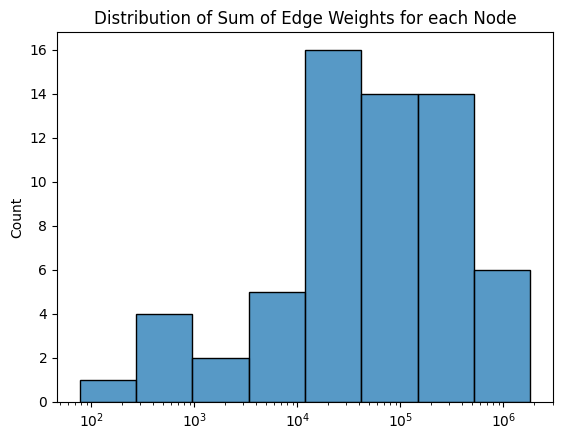

In [55]:
weighted_degree = np.array(list(nx.get_node_attributes(G_matched, "weighted_degree").values()))

df_node_weighted_degree = sns.histplot(weighted_degree, log_scale=True)

plt.title("Distribution of Sum of Edge Weights for each Node")

In [56]:
# homophily
nx.attribute_assortativity_coefficient(G_matched, 'bias')

-0.016875329402054523

The measure for homophily is almost 0. This suggests that there is no homophily. However, we have calculated weighted homophily to account for the strength of connection between channels.

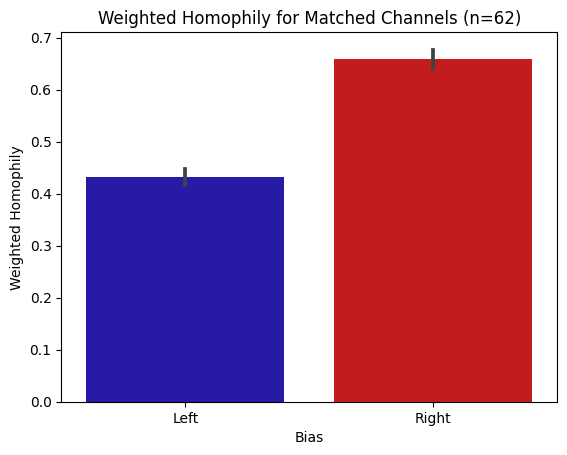

In [104]:
df_bias_homophily = pd.DataFrame([(data["weighted_homophily"], data["bias"]) for node, data in G_matched.nodes().data()], columns=["weighted_homophily", "bias"])

ax = sns.barplot(df_bias_homophily, x="bias", y="weighted_homophily", palette=BIAS_COLORS)

ax.set_xlabel("Bias")
ax.set_ylabel("Weighted Homophily")

plt.title(f"Weighted Homophily for Matched Channels (n={len(df_bias_homophily)})")

plt.savefig("./assets/bars_weighted_homophily_matched.png", dpi=500)

Wow! This suggests the opposite: Accounting for the strength of connection, homophily is much stronger.

## 4 Lexical categories

Let's investigate if there are any differences in the lexical fields used between the biases.

In [58]:
df_videos = pd.read_csv("data/df_videos.csv.gz")
df_news = pd.read_csv("data/df_news.csv.gz")

In [59]:
from empath import Empath
lexicon = Empath()

In [60]:
df_categories = df_videos[["display_id", "channel_id", "tags", "description", "title"]].copy()
df_categories = pd.merge(df_categories, df_news[["channel_id", "channel_title", "bias"]], on="channel_id")
df_categories = df_categories[(~df_categories.description.isna())].copy()
df_categories = df_categories[(~df_categories.title.isna())].copy()

In [61]:
def get_lexical_categories(df):
  lexs = []

  for bias in df.bias.unique():
    descriptions = list(df[df.bias == bias].title)

    lex = lexicon.analyze(descriptions, normalize=True)

    lexs.append(pd.DataFrame(lex, index=[bias]))

  return pd.concat(lexs)

In [67]:
df_lexical

help    office     dance     money   wedding  domestic_work  \
Center  0.001800  0.002520  0.001176  0.005355  0.002394       0.001533   
Right   0.002358  0.002756  0.000683  0.005647  0.002868       0.001073   
Left    0.001243  0.001695  0.000631  0.002448  0.001891       0.000964   

           sleep  medical_emergency      cold      hate  ...    weapon  \
Center  0.000444           0.001932  0.001442  0.000528  ...  0.003386   
Right   0.000376           0.001994  0.000742  0.000967  ...  0.003807   
Left    0.000269           0.001585  0.000868  0.000549  ...  0.002935   

        children   monster     ocean    giving  contentment   writing  \
Center  0.002565  0.000307  0.001029  0.002159     0.000267  0.000640   
Right   0.002450  0.000416  0.000857  0.002746     0.000229  0.001132   
Left    0.002021  0.000350  0.000807  0.001444     0.000165  0.000450   

           rural  positive_emotion   musical  
Center  0.000763          0.002034  0.001532  
Right   0.000489          0.002259  0.001184  
Left    0.000482          0.001304  0.000971  

[3 rows x 194 columns]

<AxesSubplot: title={'center': 'Lexical Similarity'}>

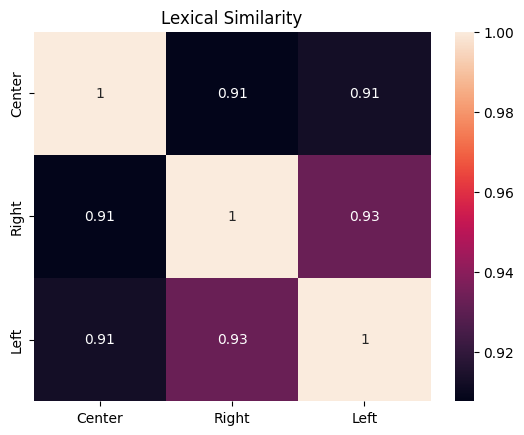

In [62]:
df_lexical = get_lexical_categories(df_categories)

plt.title("Lexical Similarity")
sns.heatmap(df_lexical.T.corr(), annot=True)

<AxesSubplot: title={'center': 'Lexical Similarity for Video Titles Containing Trump'}>

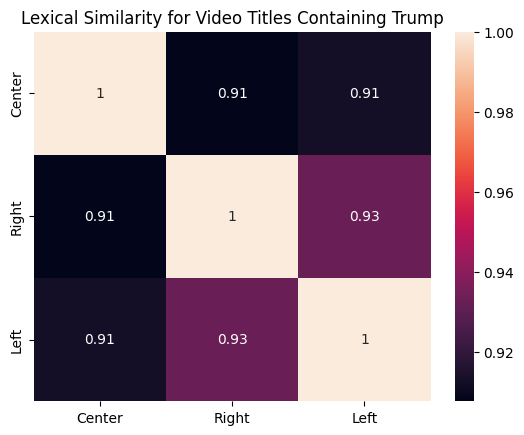

In [63]:
fig = plt.Figure()

df_lexical = get_lexical_categories(df_categories)

df_categories_trump = df_categories[df_categories.title.str.lower().str.contains("trump")].copy()

plt.title("Lexical Similarity for Video Titles Containing Trump")
sns.heatmap(df_lexical.T.corr(), annot=True)

## 5 Title sentiment for diferent keywords in video titles

Let's investigate some of the topics we have identified above.

In [64]:
df_videos_sentiment = pd.read_csv("data/df_videos_sentiment.csv.gz")
df_categories_sentiment = pd.merge(df_categories, df_videos_sentiment, on="display_id")

In [68]:
df_categories_sentiment.head()

display_id                channel_id             tags      description  \
0  6WtuYj2w02I  UCz8K1occVvDTYDfFo7N5EZw  LawNewz Network  LawNewz Network   
1  YFH6b3xuFJ0  UCz8K1occVvDTYDfFo7N5EZw  LawNewz Network  LawNewz Network   
2  WHEg1n74TJ8  UCz8K1occVvDTYDfFo7N5EZw  LawNewz Network  LawNewz Network   
3  KkA6hffR7sg  UCz8K1occVvDTYDfFo7N5EZw  LawNewz Network  LawNewz Network   
4  7XCXvOMRy4g  UCz8K1occVvDTYDfFo7N5EZw  LawNewz Network  LawNewz Network   

                             title      channel_title    bias  negative  \
0         LawNewz Network 08/18/17  Law&Crime Network  Center  0.091971   
1         LawNewz Network 08/17/17  Law&Crime Network  Center  0.089764   
2  LawNewz Network 08/15/17 Part 1  Law&Crime Network  Center  0.070045   
3         LawNewz Network 08/14/17  Law&Crime Network  Center  0.092396   
4         LawNewz Network 08/11/17  Law&Crime Network  Center  0.094195   

    neutral  positive  
0  0.871520  0.036509  
1  0.875371  0.034865  
2  0.899621  0.030335  
3  0.870708  0.036896  
4  0.871171  0.034635

In [65]:
key_words = [
  "all",
  "trump",
  "obama",
  # "obamacare"
  "north korea",
]

key_word_sentiments = []

for key_word in key_words:
  df_categories_topic = df_categories_sentiment.copy()

  if key_word != "all":
    df_categories_topic = df_categories_sentiment[df_categories_sentiment.title.str.lower().str.contains(key_word)].copy()

  # get average sentiment scores 
  df_bias_sentiment = df_categories_topic.groupby("bias").mean(numeric_only=True).reset_index().melt("bias")
  df_bias_sentiment.rename(dict(variable="sentiment", value="score"), axis=1, inplace=True)
  df_bias_sentiment = df_bias_sentiment[(df_bias_sentiment.bias != "Center") & (df_bias_sentiment.sentiment != "neutral")].copy()

  # get individual values for this key word
  neg_left = df_bias_sentiment.loc[(df_bias_sentiment.sentiment == "negative") & (df_bias_sentiment.bias == "Left"), "score"].values[0]
  neg_right = df_bias_sentiment.loc[(df_bias_sentiment.sentiment == "negative") & (df_bias_sentiment.bias == "Right"), "score"].values[0]
  pos_left = df_bias_sentiment.loc[(df_bias_sentiment.sentiment == "positive") & (df_bias_sentiment.bias == "Left"), "score"].values[0]
  pos_right = df_bias_sentiment.loc[(df_bias_sentiment.sentiment == "positive") & (df_bias_sentiment.bias == "Right"), "score"].values[0]

  # calculate ratios
  # a ration <0 mean stronger on the left, >0 stronger on the right
  neg_ratio = neg_right/neg_left - 1
  # ttest to show significance
  p = stats.ttest_ind(df_categories_topic[df_categories_topic.bias == "Right"].negative, df_categories_topic[df_categories_topic.bias == "Left"].negative).pvalue
  key_word_sentiments.append(("negative", neg_ratio, key_word, p))

  pos_ratio = pos_right/pos_left - 1
  p = stats.ttest_ind(df_categories_topic[df_categories_topic.bias == "Right"].positive, df_categories_topic[df_categories_topic.bias == "Left"].positive).pvalue
  key_word_sentiments.append(("positive", pos_ratio, key_word, p))

df_key_word_sentiment_by_bias = pd.DataFrame(key_word_sentiments, columns=("sentiment", "ratio", "key_word", "p_value"))
df_key_word_sentiment_by_bias.key_word = [" ".join([word.capitalize() for word in key_word.split()]) for key_word in df_key_word_sentiment_by_bias.key_word]
df_key_word_sentiment_by_bias.sentiment = [sentiment.capitalize() for sentiment in df_key_word_sentiment_by_bias.sentiment]
df_key_word_sentiment_by_bias.columns = [column.capitalize() for column in df_key_word_sentiment_by_bias.columns]

df_key_word_sentiment_by_bias.head()

Sentiment     Ratio Key_word        P_value
0  Negative  0.091688      All  2.114290e-117
1  Positive -0.041906      All   4.243919e-11
2  Negative -0.083490    Trump   2.695859e-22
3  Positive  0.318478    Trump   2.451128e-61
4  Negative  0.578397    Obama  3.573003e-120

The p-values for the t-tests are _low_ or even _extremely low_, these are significant differences!

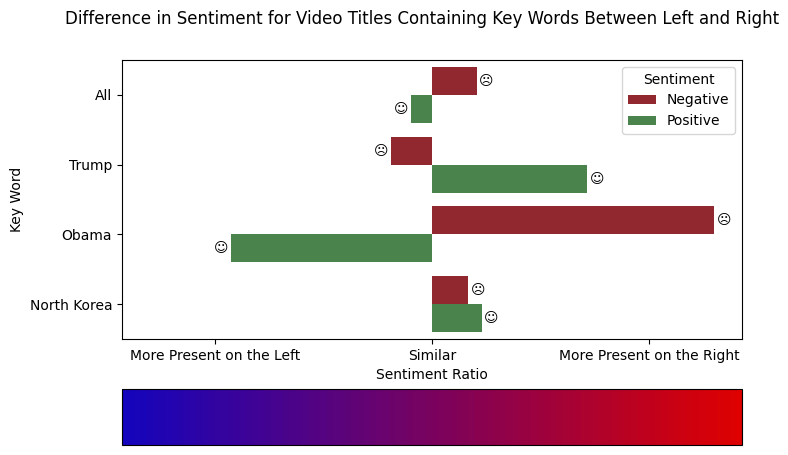

In [121]:
fig = plt.figure(figsize=(8,5))

spec = plt.GridSpec(ncols=1, nrows=2, hspace=0.3, height_ratios=[5, 1])

fig.suptitle("Difference in Sentiment for Video Titles Containing Key Words Between Left and Right")

ax1 = fig.add_subplot(spec[0])

sns.barplot(df_key_word_sentiment_by_bias, y="Key_word", x="Ratio", hue="Sentiment", palette=dict(Negative="#A31621", Positive="#408C44"))

max_val = max(abs(min(df_key_word_sentiment_by_bias.Ratio)), abs(max(df_key_word_sentiment_by_bias.Ratio)))
max_val *= 1.1
ax1.set_xlim(xmin=-max_val, xmax=max_val)

ax1.set_xlabel("Sentiment Ratio")
ax1.set_ylabel("Key Word")

ax1.bar_label(ax1.containers[0], labels=["☹"]*(len(df_key_word_sentiment_by_bias)//2), padding=2)
ax1.bar_label(ax1.containers[1], labels=["☺"]*(len(df_key_word_sentiment_by_bias)//2), padding=2)

max_val *= 0.7
ax1.set(xticks=(-max_val, 0, max_val), xticklabels=["More Present on the Left", "Similar", "More Present on the Right"])

ax2 = fig.add_subplot(spec[1])
cm = mpl.colors.LinearSegmentedColormap.from_list("Custom", (BIAS_COLORS["Left"], BIAS_COLORS["Right"]), N=100)

fig.colorbar(mpl.cm.ScalarMappable(cmap=cm), cax=ax2, orientation="horizontal")

ax2.set(xticks=[])

plt.savefig("./assets/bars_sentiment_for_key_words.png", dpi=500)

## 6 Filter bubbles (aggregate scores)

In this study, we made the assumption that by analyzing the comments left by YouTube users on various videos, we can infer their viewing preferences and political bias. The AllSides foundation has labeled certain news channels as having a political bias. Based on this information and our assumption about inferring preferences, we have attempted to infer the political bias of YouTube users by aggregating the metadata of the videos they have commented on.

To do this, we have calculated scores for each user in two different ways:

1. As a sum: We have assigned a score to each user by adding up the political leanings of the videos they have commented on, using the following scores: -1 for left-wing, -0.5 for left-leaning, 0 for center, 0.5 for right-leaning, and 1 for right-wing. For example, a score of -500 means that the user has left 500 more comments on left-wing channels than on other channels. A score of 0 indicates that the user has commented equally on right- and left-wing channels. We hypothesized that in a filter bubble scenario, we would observe a higher frequency of extreme scores compared to moderate scores, resulting in a bimodal distribution with means of the modes significantly different from 0.

2. As a ratio with a domain of (0,1): We have calculated a score for each user by dividing the number of right-wing videos they have commented on by the total number of biased videos they have commented on. A ratio of 0 indicates that the user has only watched left-wing videos, while a ratio of 0.5 indicates that the user has commented on an equal number of left- and right-wing videos.

In both cases, commenting on a video with no political bias (labeled as "center") has no effect on the user's score.


### 6.1 Data Exploration

In [ ]:
df_comments = pd.merge(pd.read_csv('data/df_people_channel.csv.gz',compression='gzip', dtype='category'),\
         pd.read_csv('data/df_nodes.csv'),\
         right_on="Id",left_on="channel_id").drop('Id',axis=1)
#df_comments = pd.read_pickle('data/var_df_comments.pkl')

# Transform media_bias_rating to numbers to be able to aggregate them
df_comments['media_bias_rating'] = df_comments['media_bias_rating'].map({'Left':-1,'Lean Left':-0.5,'Right':1,'Center':0,'Lean Right':0.5}) 
df_comments.head(1)

channel_id   author     video_id  channel_title  \
0  UCrvhNP_lWuPIP6QZzJmM-bw  8950712  3g7BY6sRhnU  New York Post   

   media_bias_rating    color                       Label  
0                0.5  #ff6766  New York Post (Lean Right)

Counts of authors, channels and videos.

In [ ]:
df_comments[['channel_id','author','video_id']].describe()

channel_id     author     video_id
count                  113260595  113260595    113260595
unique                       137   15009226       267606
top     UCupvZG-5ko_eiXAupbDfxWw    8819632  faI8kacPGbQ
freq                    18008087      24927       146206

Let's look at the youtube comment authors in our dataset. Specifically, the number of comments for each author:

In [ ]:
authors = df_comments.author.value_counts()
authors.describe().apply('{0:.1f}'.format)


count    18084101.0
mean            6.3
std            57.5
min             0.0
25%             1.0
50%             1.0
75%             3.0
max         24927.0
Name: author, dtype: object

The distribution of comments over authors. We notice the distribution is not exactly a power law. This is slightly problematic, and motivates the ways in which we try to make more "fair" comparisons between authors and their comments.

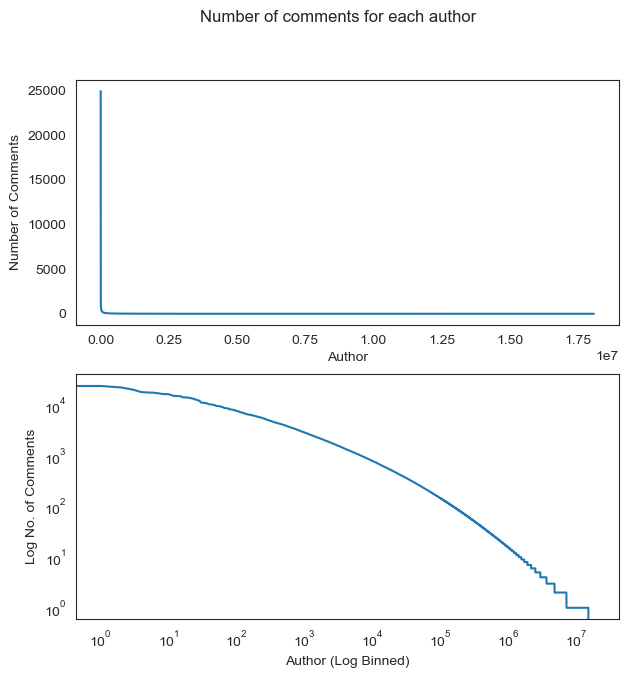

In [ ]:
# reset index to make it easier to use lineplot
authors = authors.reset_index().drop('index',axis=1).reset_index()
authors_plot, authors_plot_axs = plt.subplots(2, 1)

sns.lineplot(ax=authors_plot_axs[0], data=authors, x='index', y='author')
authors_plot_axs[0].set(xlabel='Author', ylabel='Number of Comments')

sns.lineplot(ax=authors_plot_axs[1], data=authors, x='index', y='author')
authors_plot_axs[1].set(xlabel='Author (Log Binned)', ylabel='Log No. of Comments', xscale='log', yscale='log')

authors_plot.set(size_inches= (7, 7))
authors_plot.suptitle('Number of comments for each author')

plt.savefig("./assets/authors_comments.png", dpi=400)

pickle.dump((authors_plot, authors_plot_axs), open('data/var_authors_plot_authors_plot_axs.pkl', 'wb'))

# authors_plot, authors_plot_axs = pickle.load(open('data/var_authors_plot_authors_plot_axs.pkl','rb'))

In [ ]:
del authors_plot, authors_plot_axs # optimize memory

How many **unique** channels and videos authors commented in the dataset. The median author comments on 1 unique video and channel respectively. While top quartile authors comment on at least 3 and 2 respectively.

In [ ]:
authors_stats = df_comments.groupby(['author']).nunique().describe()
authors_stats = authors_stats.apply(lambda s: s.apply('{0:.1f}'.format))
# authors_stats = pickle.load(open('data/var_authors_stats','rb'))
# authors_stats

In [ ]:
del authors, authors_stats # memory optimization

The distribution of comments over political factions

In [ ]:
g = sns.catplot(data=df_comments, x="media_bias_rating", kind="count",order=[-1,-0.5,0,0.5,1], palette='vlag')\
            .set_xticklabels(['Left','Lean Left','Center','Lean Right','Right'])\
            .set(xlabel="Bias of Channel", ylabel="Number of Comments", \
                title="Number of comments on channels of a certain bias")

plt.savefig("./assets/comments_by_bias.png", dpi=400)

: 

: 

### 6.2 Pre-Analysis

In [ ]:
# Transform some columns from categorical to numeric. When filtering datasets and then showing value 
# counts or histplots, the categories that have been filtered out will show as 0. This was not 
# desirable for the following analyses. So we decided to convert them to numeric instead of having
# to filter the 0 categories out every time.
df_comments.media_bias_rating = pd.to_numeric(df_comments.media_bias_rating)
df_comments.author = pd.to_numeric(df_comments.author)

We don't know if our sample of comments reflects the population distribution of comments over political biases. As shown before, left wing comments dominate in our dataset. When looking at probabilities, if a user can only watch videos from our dataset, they are more likely to watch left wing videos just because there are much more of them! 

We construct a new dataset, where the channels have been matched by propensity scores based on more broad channel covariates (viewcount etc.), as has been used in other parts of the notebook

In [ ]:
df_channels_matched = pd.read_csv('data/df_news_matched.csv')
df_comments_matched = df_comments[df_comments.channel_id.isin(df_channels_matched.channel_id)]
df_comments_matched.shape

(42368607, 7)

Remove commenters that commented under 100 times. We assume that authors with less than 100 comments could be thought of as casual commenters that have stumbled on the channels by chance. This filtering increases the confidence when doing inference for particular authors. 

In [ ]:
df_comments_matched = df_comments_matched[df_comments_matched.groupby('author')['author'].transform('size') > 99]

In [ ]:
df_comments_matched.shape

Let's see how the distribution of comments over channel biases is on this matched dataset.

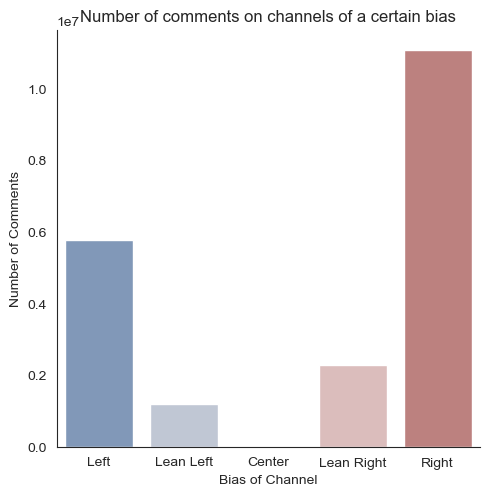

In [ ]:
sns.catplot(data=df_comments_matched, x="media_bias_rating", kind="count",order=[-1,-0.5,0,0.5,1], palette='vlag')\
            .set_xticklabels(['Left','Lean Left','Center','Lean Right','Right'])\
            .set(xlabel="Bias of Channel", ylabel="Number of Comments", \
                title="Number of comments on channels of a certain bias")

### 6.3 Analysis 1: Aggregate the political bias of an author as a sum

In the first part of our analysis, we aggregated the political bias of each comment author by summing up the political leanings of the videos they commented on. We used the following scores: -1 for left-wing, -0.5 for left-leaning, 0 for center, 0.5 for right-leaning, and 1 for right-wing.

For example, a score of -500 indicates that the comment author has left 500 more comments on left-wing channels than on other channels, and we consider this person to be biased. On the other hand, a score of 0 means that the comment author has left an equal number of comments on right- and left-wing channels, and we consider this person to be unbiased.

Our hypothesis is that in a situation where people are only exposed to information that confirms their existing beliefs (a "filter bubble"), we will see a higher frequency of extreme scores compared to moderate scores, resulting in a bimodal distribution with means of the modes significantly different from 0.

In [ ]:
def bias_sum_by_author(df_comments,lower_bound,upper_bound):
    """Groupby author, and then for each author, sum the biases of the videos on which 
    they commented on. Sort the values, and then remove some of the outliers with
    lower and upper bounds. Return a series with the index as unique comment author names, 
    and their "aggregate bias score" after the filtering as values.

    :param comments_treshold: treshold for minimum number of comments
    :param lower_bound: lower bound for values (measured from the beginning of array)
    :param upper_bound: upper bound for values (measured from the end of array)


    """
    return df_comments.groupby('author')['media_bias_rating']\
                      .sum()\
                      .sort_values()\
                      .iloc[lower_bound:upper_bound]

The result is as we predicted, after an sum aggregate of each author's biases we see that they authors seem to come from a bimodal distribution - a mode for left and a mode for right wing bias!

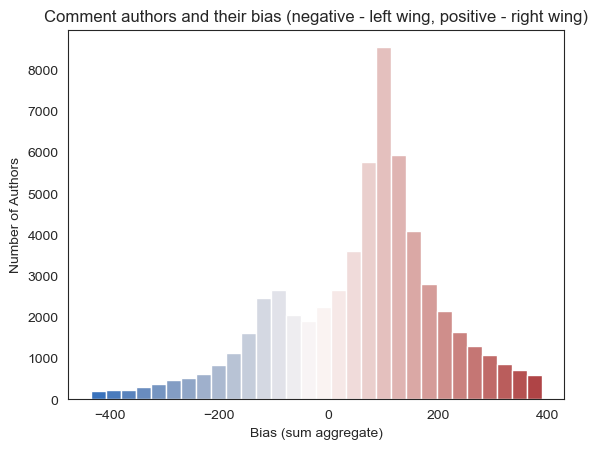

In [ ]:
g = sns.histplot(x=bias_sum_by_author(df_comments_matched,lower_bound=2000,upper_bound=-5000), bins=30)
g.set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
g.set_xlabel('Bias (sum aggregate)')
g.set_ylabel('Number of Authors')

for bin_,i in zip(g.patches,sns.color_palette('vlag',30)):
    bin_.set_facecolor(i)

plt.savefig('./assets/authors_bias_sum.png', dpi=400)

### 6.4 Analysis 2: Aggregate the political bias of an author as a ratio

In the second part of our analysis, we looked at the political bias of each comment author as a ratio, without taking into account the number of comments made by each person. This allows us to focus on the direction of an author's comments, rather than the magnitude.

To calculate these scores, we divided the number of right-wing videos commented on by the total number of biased videos commented on. A score of 0 indicates that the comment author has only watched left-wing videos, while a score of 0.5 indicates that they have commented on an equal number of left- and right-wing videos.

This second analysis allows us to further explore this effect by focusing on the direction of comments, rather than the quantity.

In [ ]:
def bias_ratio_by_author(df_comments):
    """Groupby author and media bias rating, and then for each author, unstack
    the bias categories and count occurences. Return a dataframe with the 
    with the "ratio score", i.e. the ratio of right wing to right + left wing 
    videos commented on.

    """
    df = df_comments.groupby(['author','media_bias_rating'])\
               .size()\
               .unstack(fill_value=0)
    # Right wing videos / (right + left wing videos)
    df['ratio'] = (df[1.0]+df[0.5])/(df[-1.0]+df[-0.5]+df[1.0]+df[0.5])
    df = df.dropna()
    return df

In [ ]:
# again filtering for only commenters with more than 100 comments
bias_ratio_by_author(df_comments_matched).head()

media_bias_rating  -1.0  -0.5  0.5  1.0     ratio
author                                           
8604                  5    14   30   82  0.854962
9490                302     8    4    1  0.015873
28277                 0     6   15  190  0.971564
45346                 2    19   58   30  0.807339
50128                 6     1   12   87  0.933962

The results of this analysis are even more striking than before. When we adjust for the differences in the number of comments made by each author, the "filter bubble" effect is even more pronounced. It appears that authors most frequently watch videos from only one political faction.

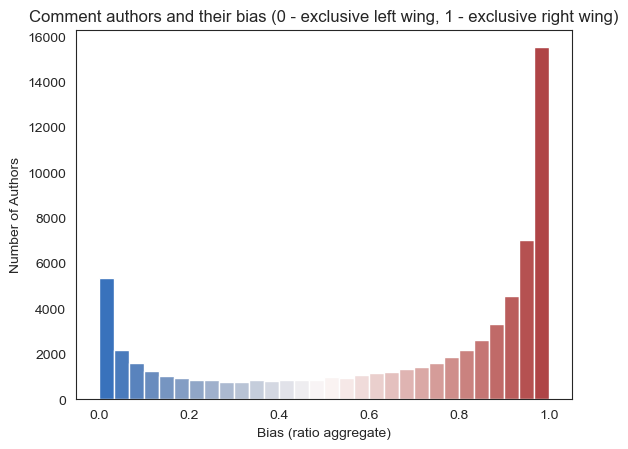

In [ ]:
g = sns.histplot(data=bias_ratio_by_author(df_comments_matched), x='ratio',bins=30)
g.set_title('Comment authors and their bias (0 - exclusive left wing, 1 - exclusive right wing)')
g.set_xlabel('Bias (ratio aggregate)')
g.set_ylabel('Number of Authors')

for bin_,i in zip(g.patches,sns.color_palette("vlag",30)):
    bin_.set_facecolor(i)

plt.savefig("./assets/authors_bias_ratio.png", dpi=400)

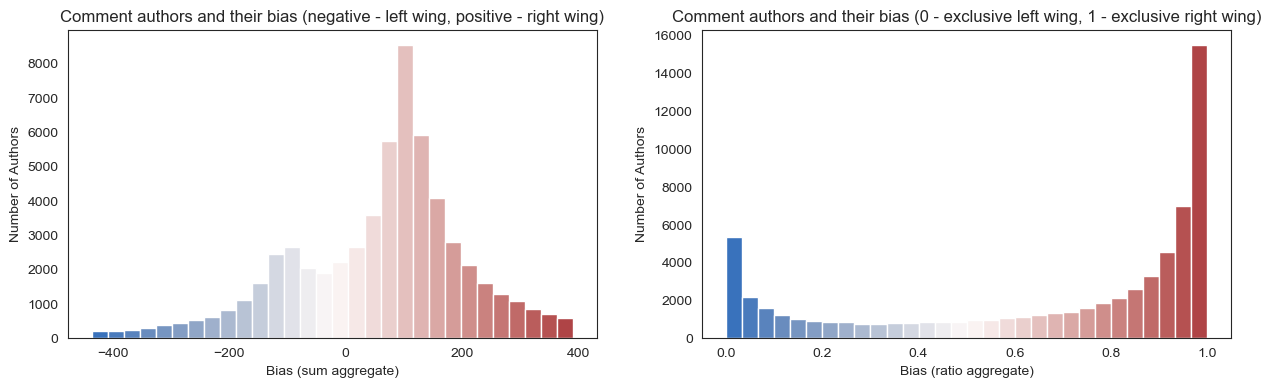

In [ ]:
#viewed together

fig, axs = plt.subplots(1, 2)
fig.set(size_inches= (15, 4))

sns.histplot(x=bias_sum_by_author(df_comments_matched,lower_bound=2000,upper_bound=-5000), bins=30, ax=axs[0])
axs[0].set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
axs[0].set_xlabel('Bias (sum aggregate)')
axs[0].set_ylabel('Number of Authors')

for bin_,i in zip(axs[0].patches,sns.color_palette("vlag",30)):
    bin_.set_facecolor(i)

sns.histplot(data=bias_ratio_by_author(df_comments_matched), x='ratio',bins=30, ax=axs[1],)
axs[1].set_title('Comment authors and their bias (0 - exclusive left wing, 1 - exclusive right wing)')
axs[1].set_xlabel('Bias (ratio aggregate)')
axs[1].set_ylabel('Number of Authors')

for bin_,i in zip(axs[1].patches,sns.color_palette("vlag",30)):
    bin_.set_facecolor(i)

plt.savefig("./assets/authors_bias_ratio_sum.png", dpi=400)

## 7 First Order Connections

In [ ]:
# read dataframes
df_connections = pd.read_csv("data/df_graph.csv.gz", compression="gzip")
df_channels = pd.read_csv("data/df_news_matched.csv.gz", compression="gzip")

In [ ]:
# filter df_graph such that only that matched channels are considered (df_graph was generated using the unmatched channel dataset)
df_connections = df_connections[df_connections.channel1.isin(df_channels.channel_id) & 
    df_connections.channel2.isin(df_channels.channel_id)].copy()

In [ ]:
# only consider connections with weights > 500
df_connections = df_connections[df_connections["weight"] > 500]

df_connections.head(5)

channel1                  channel2  weight
1  UCP4BdwPKyYnfRLjSNfGAPRA  UCXIJgqnII2ZOINSWNOGFThA   42041
2  UCP4BdwPKyYnfRLjSNfGAPRA  UCaXkIU1QidjPwiAYu6GcHjg   18956
3  UCP4BdwPKyYnfRLjSNfGAPRA  UCuFFtHWoLl5fauMMD5Ww2jA   10257
4  UCXIJgqnII2ZOINSWNOGFThA  UCaXkIU1QidjPwiAYu6GcHjg  255154
5  UCXIJgqnII2ZOINSWNOGFThA  UCuFFtHWoLl5fauMMD5Ww2jA  105309

In [ ]:
# drop center and mixed cases, combine lean left and left, combine lean right and right
#df_channels.drop((df_channels[(df_channels["media_bias_rating"] == "Center") | (df_channels["media_bias_rating"] == "Mixed")]).index, axis=0, inplace=True)
df_channels["media_bias_rating"] = df_channels["media_bias_rating"].apply(lambda bias: "Left" if bias == "Lean Left" else bias)
df_channels["media_bias_rating"] = df_channels["media_bias_rating"].apply(lambda bias: "Right" if bias == "Lean Right" else bias)

df_channels.head(5)

source_name source_type media_bias_rating  \
0  America's 1st Freedom  News Media             Right   
1     Atlanta Black Star  News Media              Left   
2              Bloomberg  News Media              Left   
3         Breitbart News  News Media             Right   
4   Catholic News Agency  News Media             Right   

                            source_url                channel_id  \
0  https://www.americas1stfreedom.org/  UCZr49eSL2aHQ_41476IrkbA   
1        https://atlantablackstar.com/  UC1hxUKIonH_8N7Xqj65IEsg   
2            http://www.bloomberg.com/  UCIALMKvObZNtJ6AmdCLP7Lg   
3            http://www.breitbart.com/  UCmgnsaQIK1IR808Ebde-ssA   
4  https://www.catholicnewsagency.com/  UCaJBwb7XkojUOPbz_6uzPag   

                   channel_title  \
0                            NRA   
1             Atlanta Black Star   
2  Bloomberg Markets and Finance   
3                 Breitbart News   
4             catholicnewsagency   

                                 channel_description      category_cc  \
0                                                NaN  News & Politics   
1  Atlanta Black Star is a narrative company. We ...  News & Politics   
2  The latest financial news and market analysis,...  News & Politics   
3                                                NaN  News & Politics   
4  Catholic News Agency (CNA) provides reliable, ...  News & Politics   

    join_date  subscribers_cc  videos_cc  subscriber_rank_sb  weights   bias  \
0  2006-10-12          179000       4250             96398.0   3.6115  Right   
1  2016-03-01           19900        418            542636.0   7.1970   Left   
2  2017-05-03          398000      15480             34997.0   3.2190   Left   
3  2015-02-24          137000       2210            117307.0   4.5410  Right   
4  2007-04-11           13700       1178            730984.0  10.8400  Right   

     color  
0  #de0100  
1  #1404bd  
2  #1404bd  
3  #de0100  
4  #de0100

In [ ]:
# add bias to connections dataframe
df_connections_bias = pd.merge(df_connections, 
    df_channels[["channel_id", "media_bias_rating"]], 
    left_on="channel1", 
    right_on="channel_id")
df_connections_bias.drop("channel_id", axis="columns", inplace=True)
df_connections_bias.rename(columns={"media_bias_rating": "bias1"}, inplace=True)

df_connections_bias = pd.merge(df_connections_bias, 
    df_channels[["channel_id", "media_bias_rating"]], 
    left_on="channel2", 
    right_on="channel_id")
df_connections_bias.drop("channel_id", axis="columns", inplace=True)
df_connections_bias.rename(columns={"media_bias_rating": "bias2"}, inplace=True)

df_connections_bias.head(5)

channel1                  channel2  weight  bias1  bias2
0  UCP4BdwPKyYnfRLjSNfGAPRA  UCXIJgqnII2ZOINSWNOGFThA   42041  Right  Right
1  UCCXoCcu9Rp7NPbTzIvogpZg  UCXIJgqnII2ZOINSWNOGFThA  242540  Right  Right
2  UCHd62-u_v4DvJ8TCFtpi4GA  UCXIJgqnII2ZOINSWNOGFThA  138515   Left  Right
3  UCL9PlYkRD3Q-RZca6CCnPKw  UCXIJgqnII2ZOINSWNOGFThA   38224  Right  Right
4  UC8Su5vZCXWRag13H53zWVwA  UCXIJgqnII2ZOINSWNOGFThA   80845   Left  Right

In [ ]:
# check if same or opposite biases (seperate columns are used since legacy analysis required it)
def same(row):
    if ((row["bias1"] == "Left") and (row["bias2"] == "Left"))\
        or ((row["bias1"] == "Right") and (row["bias2"] == "Right")):
        return 1
    else:
        return 0

def opposite(row):
    if ((row["bias1"] == "Left") and (row["bias2"] == "Right"))\
        or ((row["bias1"] == "Right") and (row["bias2"] == "Left")):
        return 1
    else:
        return 0

df_connections_bias["same"] = df_connections_bias.apply(lambda row: same(row), axis=1)
df_connections_bias["opposite"] = df_connections_bias.apply(lambda row: opposite(row), axis=1)

df_connections_bias.head(5)

channel1                  channel2  weight  bias1  bias2  \
0  UCP4BdwPKyYnfRLjSNfGAPRA  UCXIJgqnII2ZOINSWNOGFThA   42041  Right  Right   
1  UCCXoCcu9Rp7NPbTzIvogpZg  UCXIJgqnII2ZOINSWNOGFThA  242540  Right  Right   
2  UCHd62-u_v4DvJ8TCFtpi4GA  UCXIJgqnII2ZOINSWNOGFThA  138515   Left  Right   
3  UCL9PlYkRD3Q-RZca6CCnPKw  UCXIJgqnII2ZOINSWNOGFThA   38224  Right  Right   
4  UC8Su5vZCXWRag13H53zWVwA  UCXIJgqnII2ZOINSWNOGFThA   80845   Left  Right   

   same  opposite  
0     1         0  
1     1         0  
2     0         1  
3     1         0  
4     0         1

In [ ]:
# populate dataframes with counts of first order channel connections with same bias
df_connections_same = df_connections_bias[["channel1", "same"]].groupby("channel1").sum().merge(
    df_connections_bias[["channel2", "same"]].groupby("channel2").sum(),
    how="outer",
    left_index=True,
    right_index=True
)
df_connections_same.fillna(0, inplace=True)
df_connections_same["same"] = pd.DataFrame(df_connections_same["same_x"] + df_connections_same["same_y"])
df_connections_same.drop(columns=["same_x", "same_y"], inplace=True)

# populate dataframes with counts of first order channel connections with opposite bias
df_connections_opposite = df_connections_bias[["channel1", "opposite"]].groupby("channel1").sum().merge(
    df_connections_bias[["channel2", "opposite"]].groupby("channel2").sum(),
    how="outer",
    left_index=True,
    right_index=True
)
df_connections_opposite.fillna(0, inplace=True)
df_connections_opposite["opposite"] = pd.DataFrame(df_connections_opposite["opposite_x"] + df_connections_opposite["opposite_y"])
df_connections_opposite.drop(columns=["opposite_x", "opposite_y"], inplace=True)

# combine same and opposite dataframes
df_foc = df_connections_same.join(df_connections_opposite)

df_foc.head(5)

same  opposite
UC0p5jTq6Xx_DosDFxVXnWaQ  13.0      19.0
UC0uVZd8N7FfIZnPu0y7o95A  26.0      22.0
UC1Z1i5ClfrJhyu9z1hlmDkQ   9.0      14.0
UC1hxUKIonH_8N7Xqj65IEsg   8.0       3.0
UC5Vzc-I--guzURose4X6lKQ  14.0      10.0

In [ ]:
# add bias for each channel
df_foc = df_foc.merge(df_channels[["channel_id", "media_bias_rating"]]
    .set_index("channel_id"), how="inner", left_index=True, right_index=True)
df_foc.head(5)

same  opposite media_bias_rating
UC0p5jTq6Xx_DosDFxVXnWaQ  13.0      19.0              Left
UC0uVZd8N7FfIZnPu0y7o95A  26.0      22.0             Right
UC1Z1i5ClfrJhyu9z1hlmDkQ   9.0      14.0              Left
UC1hxUKIonH_8N7Xqj65IEsg   8.0       3.0              Left
UC5Vzc-I--guzURose4X6lKQ  14.0      10.0             Right

In [ ]:
# rename column names for graph plotting
df_foc.rename(columns={"same": "First order connections to channels with the same bias", 
               "opposite": "First order connections to channels with the opposite bias",
               "media_bias_rating": "Bias"}, inplace=True)
df_foc.head(5)

First order connections to channels with the same bias  \
UC0p5jTq6Xx_DosDFxVXnWaQ                                               13.0        
UC0uVZd8N7FfIZnPu0y7o95A                                               26.0        
UC1Z1i5ClfrJhyu9z1hlmDkQ                                                9.0        
UC1hxUKIonH_8N7Xqj65IEsg                                                8.0        
UC5Vzc-I--guzURose4X6lKQ                                               14.0        

                          First order connections to channels with the opposite bias  \
UC0p5jTq6Xx_DosDFxVXnWaQ                                               19.0            
UC0uVZd8N7FfIZnPu0y7o95A                                               22.0            
UC1Z1i5ClfrJhyu9z1hlmDkQ                                               14.0            
UC1hxUKIonH_8N7Xqj65IEsg                                                3.0            
UC5Vzc-I--guzURose4X6lKQ                                               10.0            

                           Bias  
UC0p5jTq6Xx_DosDFxVXnWaQ   Left  
UC0uVZd8N7FfIZnPu0y7o95A  Right  
UC1Z1i5ClfrJhyu9z1hlmDkQ   Left  
UC1hxUKIonH_8N7Xqj65IEsg   Left  
UC5Vzc-I--guzURose4X6lKQ  Right

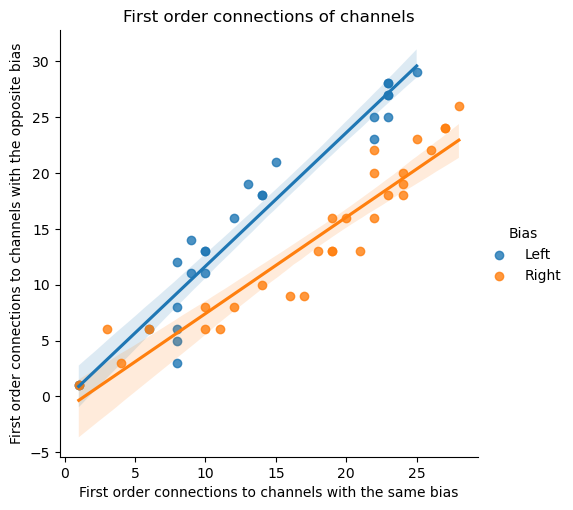

In [ ]:
# plot graph
sns.lmplot(data=df_foc,    
    x="First order connections to channels with the same bias", 
    y="First order connections to channels with the opposite bias", 
    hue="Bias",
)
plt.title("First order connections of channels")
plt.show()

## 8 LDA Video Titles

In [ ]:
# load data
df_channels = pd.read_csv("data/df_news_matched.csv.gz", compression="gzip")
df_videos = pd.read_csv("data/df_videos.csv.gz", compression="gzip")
df_videos.dropna(inplace=True)
len(df_videos)

556028

In [ ]:
# filter df_videos such that only that matched channels are considered (df_videos was generated using the unmatched channel dataset)
df_videos = df_videos[df_videos["channel_id"].isin(df_channels["channel_id"])]
len(df_videos)

187841

In [ ]:
# create docs from nlp pipeline
nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(df_videos["title"].values))
del(df_videos)

In [ ]:
# keep lemmas while removing stopwords, numbers and punctuation
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
processed_docs = []
for doc in docs:
    processed_doc = [token.lemma_.capitalize() for token in doc if not 
        token.is_punct and 
        token.lower_ not in 
        STOPWORDS and 
        len(token) > 2]
    processed_docs.append(processed_doc)

In [ ]:
# add bigrams
bigram = Phrases(processed_docs, min_count=15)
for i in range(len(processed_docs)):
    for token in bigram[processed_docs[i]]:
        if '_' in token:
            processed_docs[i].append(token)

In [ ]:
# create dictionary representation of docs
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
# fit LDA model
model = LdaMulticore(corpus=corpus, num_topics=20, id2word=dictionary, workers=6,
                passes=10, random_state=69)

In [ ]:
# plot topics
pyLDAvis.display(pyLDAvis.gensim_models.prepare(model, corpus, dictionary))

c:\Users\angol\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
# export words for perusal
dfs = []
for i in range(20):
    a = model.show_topic(i, 100)
    df = pd.DataFrame(a, columns=["word", "prob"])

    dfs.append(df)

#pd.concat(dfs, axis=1).to_excel("topics.xlsx")

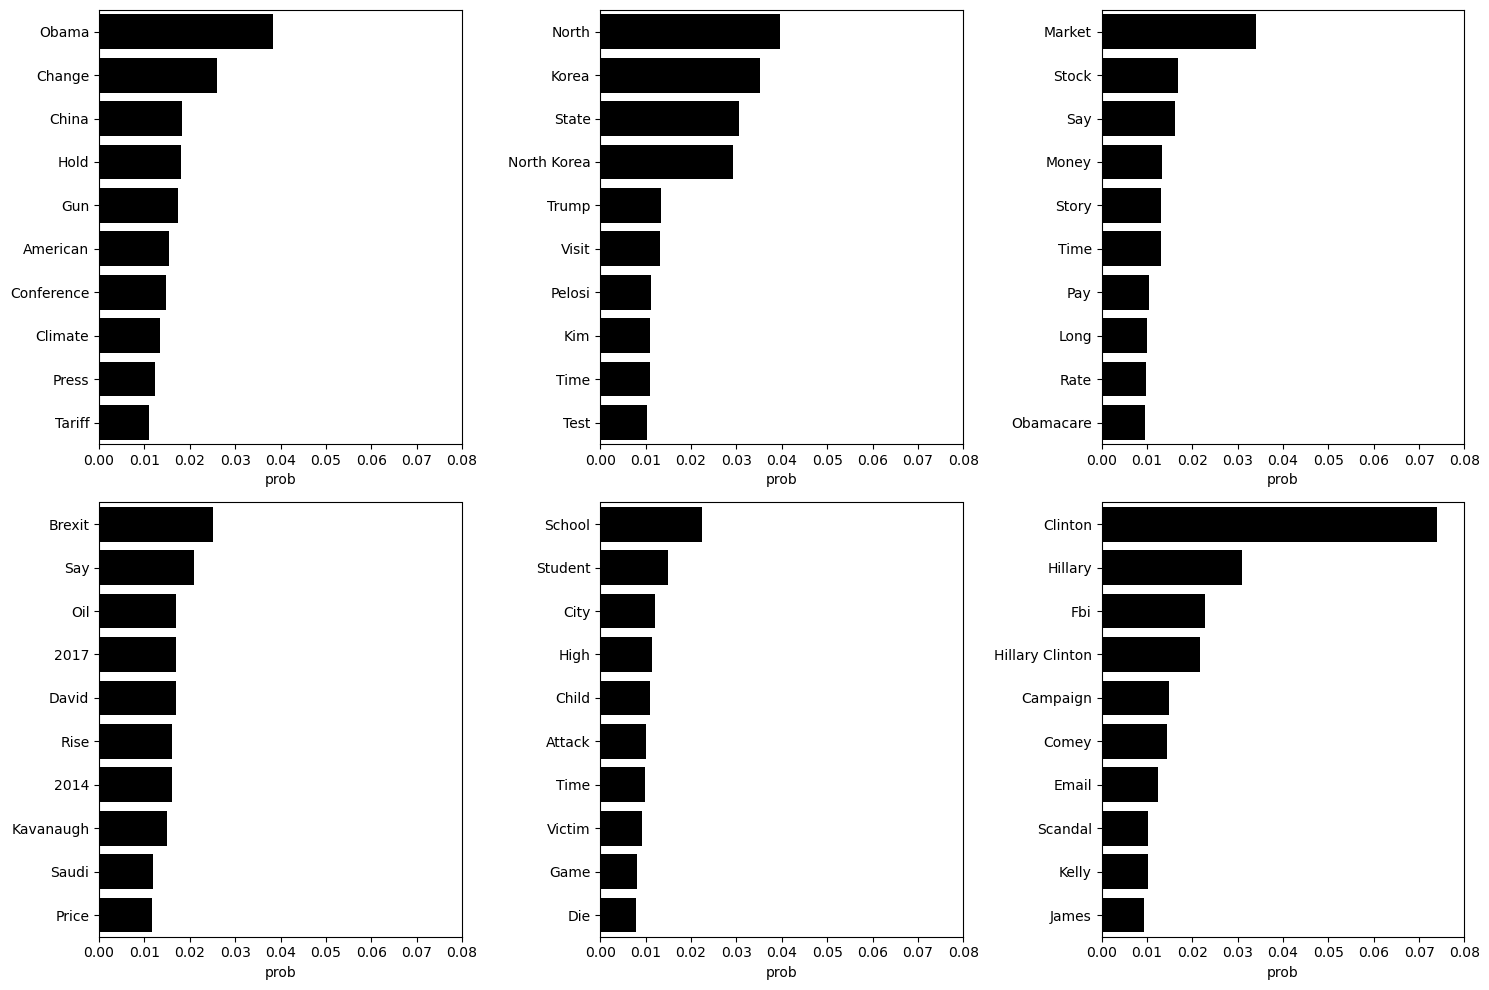

In [ ]:
# selected important topics in a horizontal bar graph
chosen_topics = [2, 4, 11, 17, 18, 19]
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows), tight_layout=True)
k = 0
for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            df_topic = pd.DataFrame(model.show_topic(chosen_topics[k], 10), columns=["word", "prob"])
            df_topic["word"] = df_topic["word"].str.replace("_"," ")
            sns.barplot(data=df_topic, x="prob", y="word", ax=ax, color="black")
            ax.set_ylabel("")
            ax.set_xlim(0, 0.08)
            k += 1

Text(0, 0.5, '')

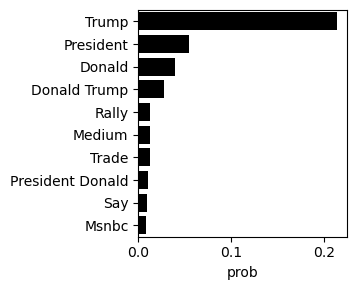

In [ ]:
# trump horizontal bar graph
fig, ax = plt.subplots(1, 1, figsize=(11/3, 3), tight_layout=True)
df_trump = pd.DataFrame(model.show_topic(6, 1000), columns=["word", "prob"])
df_trump["word"] = df_trump["word"].str.replace("_"," ")
sns.barplot(data=df_trump[:10], x="prob", y="word", ax=ax, color="black")
ax.set_ylabel("")

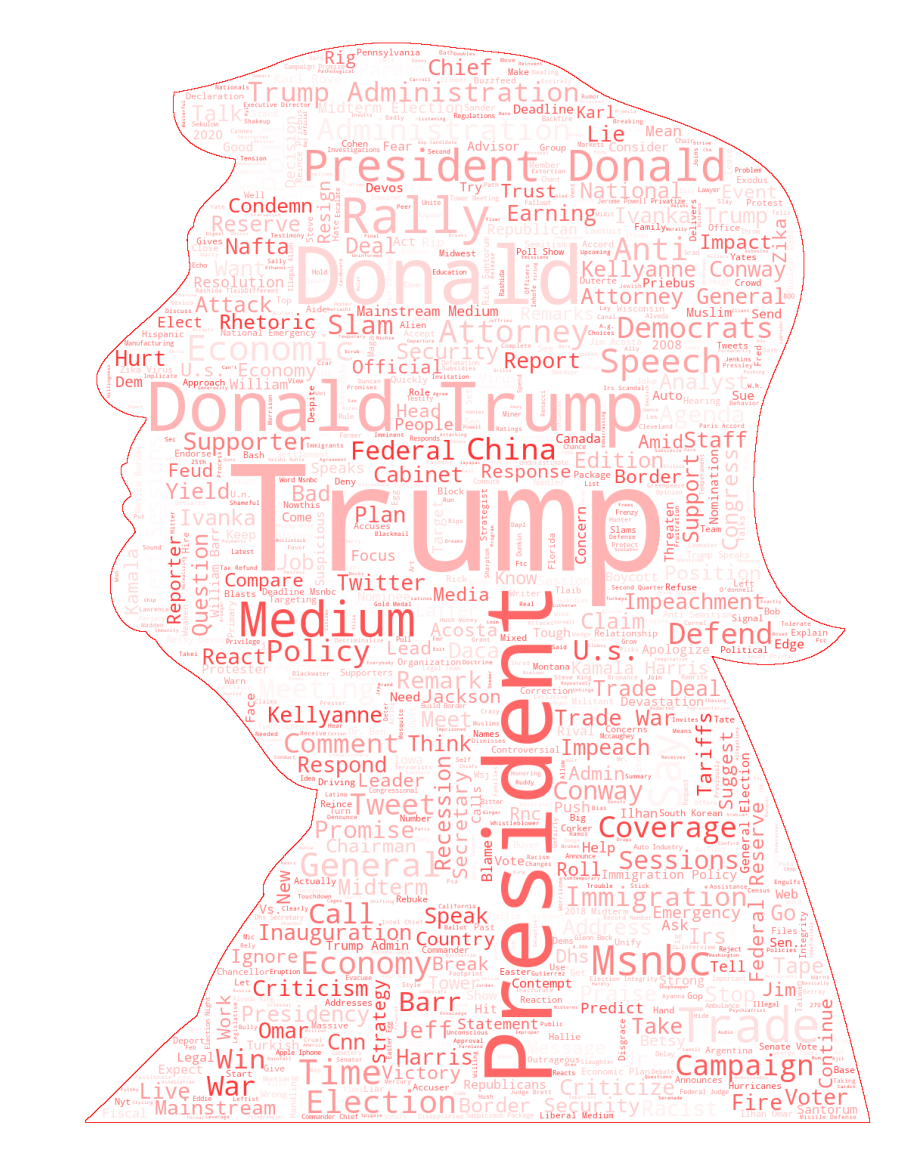

In [ ]:
# trump wordcloud
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

mask = Image.open("trump_mask.png")

wc = WordCloud(background_color="white", 
    max_words=1000, 
    width=mask.width,
    height=mask.height,
    mask=np.array(mask), 
    contour_width=1, 
    contour_color='red'
)

wc.generate_from_frequencies(dict(df_trump.values))
def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(60, 100)

fig, ax = plt.subplots(dpi=300)
ax.imshow(wc.recolor(color_func=color_func))
ax.axis("off")
fig.savefig("trump_wc.png")


## 9 Sentiment analysis pipeline
We use roberta base sentiment analysis to evaluate YouTube video title positivity. 

In [ ]:
# Reference: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
# A model provided by Huggingface
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
# Function with text as input and the sentiment score as output
def text_to_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    scores = output[0][0].detach().cpu()
    scores = softmax(scores)
    return scores.numpy()

In [ ]:
import pandas as pd
path = 'FILE_PATH' # df_videos_for_sentiment.csv.gz
df = pd.read_csv(path)
df.title = df.title.astype(str)

In [ ]:
# Do the sentiment analysis for all videos in our dataframe
sentiments = []

def save(res):
  df = pd.DataFrame(res)
  df.columns = ["display_id", "negative", "neutral", "positive"]
  df.to_csv("/content/drive/MyDrive/df_videos_sentiment.csv.gz", index=False)

for i, row in df.iterrows():
  sent_vec = text_to_sentiment(row[1])
  sentiments.append([row[0], *sent_vec])

# Save dataframe
save(sentiments)